# 중급프로젝트1 (6팀)
주제:

##### 기본세팅 및 파일 불러오기

In [ ]:
# 데이터가 있는 폴더 경로
folder_path = '/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼(로그없음)/'

# CSV 파일 목록 가져오기
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 데이터프레임을 저장할 빈 딕셔너리 생성
dfs = {}

for file_path in csv_files:
    # 파일 경로에서 파일 이름(확장자 제외) 추출
    file_name = os.path.splitext(os.path.basename(file_path))[0].lower()

    # '파일이름_df' 형식의 키 생성
    key_name = f"{file_name}_df"

    # CSV 파일을 읽어 딕셔너리에 저장
    try:
        dfs[key_name] = pd.read_csv(file_path, encoding='utf-8', index_col=0, low_memory=False)
        print(f"'{key_name}' 생성 완료")
    except Exception as e:
        print(f"'{file_name}.csv' 파일 로드 실패: {e}")

# 생성된 데이터프레임 확인
print("\n--- 생성된 데이터프레임 목록 ---")
print(list(dfs.keys()))

In [ ]:
application_df = dfs['application_df']
company_df = dfs['company_df']
job_df = dfs['job_df']
job_address_df = dfs['jobaddress_df']
jobbookmark_df = dfs['jobbookmark_df']
companyfund_df = dfs['companyfund_df']
companyaddress_df = dfs['companyaddress_df']

In [ ]:
# 로그파일의 경우 청크 방식을 채택하여 코랩의 부하를 줄이는 코드를 작성하여 따로 운용하였습니다.

In [ ]:
input_filepath = f'/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼/log_2022.csv'

chunk_size = 100000

reader = pd.read_csv(input_filepath, chunksize=chunk_size)

processed_chunks = []

print("파일 처리를 시작합니다...")
for i, chunk in enumerate(reader):
    print(f"{i+1}번째 청크 처리 중...")

    processed_chunks.append(chunk)

print("파일 처리가 완료되었습니다.")

log_2022_df = pd.concat(processed_chunks, ignore_index=True)

In [ ]:
input_filepath = f'/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼/log_2023.csv'

chunk_size = 100000

reader = pd.read_csv(input_filepath, chunksize=chunk_size)

processed_chunks = []

print("파일 처리를 시작합니다...")
for i, chunk in enumerate(reader):
    print(f"{i+1}번째 청크 처리 중...")

    processed_chunks.append(chunk)

print("파일 처리가 완료되었습니다.")

log_2023_df = pd.concat(processed_chunks, ignore_index=True)

## 전처리

#### 기본테이블 전처리

##### UTC → KST 시간대 통일

###### company

In [ ]:
#  변환 대상 컬럼
time_cols = ['cdate', 'mdate']

#  UTC → datetime 변환 후 KST로 변환 (dtype 유지)
for col in time_cols:
    company[col] = (
        pd.to_datetime(company[col], errors='coerce', utc=True)
        .dt.tz_convert('Asia/Seoul')   # UTC → KST
        .dt.tz_localize(None)          # tz 정보 제거 → datetime64[ns] 유지
    )


###### job_bookmark

In [ ]:
#  변환 대상 컬럼
time_cols = ['cdate']

# 3. UTC → datetime 변환 후 KST로 변환 (dtype 유지)
for col in time_cols:
    job_bookmark[col] = (
        pd.to_datetime(job_bookmark[col], errors='coerce', utc=True)
        .dt.tz_convert('Asia/Seoul')   # UTC → KST
        .dt.tz_localize(None)          # tz 정보 제거 → datetime64[ns] 유지
    )


###### application

In [ ]:
# 2. 변환 대상 컬럼
time_cols = ['cdate']

# 3. UTC → datetime 변환 후 KST로 변환 (dtype 유지)
for col in time_cols:
    application[col] = (
        pd.to_datetime(application[col], errors='coerce', utc=True)
        .dt.tz_convert('Asia/Seoul')   # UTC → KST
        .dt.tz_localize(None)          # tz 정보 제거 → datetime64[ns] 유지
    )


#### 로그테이블 전처리

##### 로그파일 2022년도와 2023년도 결합

In [ ]:
# 결합을 하면서 새로운 열을 추가한다. 2022년도인지 2023년도인지에 대한 식별을 한눈에 하기 위한 열이다.
log_2022_df['year'] = 2022
log_2023_df['year'] = 2023
log_df = pd.concat([log_2022_df, log_2023_df], ignore_index=True)

# date타임의 기본 시간이 UTC 기준이기떄문에 KST기준으로 하나의 새로운 열을 만든다.
log_df['timestamp_utc'] = pd.to_datetime(
    log_df['timestamp'], utc=True, errors='coerce', infer_datetime_format=True
)
log_df['timestamp_kst'] = log_df['timestamp_utc'].dt.tz_convert('Asia/Seoul')

# 코랩의 Ram 효용성을 위해 새로운 log_df를 새로 생성한다.
log_df.to_csv('/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼/log.csv',index=False)

##### URL -> Path + Query_String 분리 작업

In [ ]:
# log.csv에 존재하는 URL의 경우 Path + query_string 으로 구성되어져 있다.
# 데이터의 경향성을 눈으로 복 GroupBY와 같은 데이터 비교를 하기 위해 Path / Qyery_String 열로 각각 생성한다.

In [ ]:
input_filepath = '/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼/log.csv'
chunk_size = 100000

reader = pd.read_csv(input_filepath, chunksize=chunk_size)
processed_chunks = []

print("파일 처리를 시작합니다...")

for i, chunk in enumerate(reader):
    print(f"{i+1}번째 청크 처리 중...")

    # URL 컬럼에서 path, query_string 분리
    query_df = chunk['URL'].str.split('?', n=1, expand=True)
    query_df.columns = ['path', 'query_string']

    # 기존 데이터프레임에 추가
    processed_chunk = pd.concat([chunk, query_df], axis=1)

    # 청크 내부에서 timestamp_kst 컬럼 변환
    chunk['timestamp_kst'] = pd.to_datetime(chunk['timestamp_kst'])

    # 처리된 청크를 리스트에 추가
    processed_chunks.append(processed_chunk)

    #  메모리 해제
    del chunk, query_df
    gc.collect()

print("파일 처리가 완료되었습니다.")

# 모든 청크를 병합
log_df = pd.concat(processed_chunks, ignore_index=True)


파일 처리를 시작합니다...
1번째 청크 처리 중...
2번째 청크 처리 중...
3번째 청크 처리 중...
4번째 청크 처리 중...
5번째 청크 처리 중...
6번째 청크 처리 중...
7번째 청크 처리 중...
8번째 청크 처리 중...
9번째 청크 처리 중...
10번째 청크 처리 중...
11번째 청크 처리 중...
12번째 청크 처리 중...
13번째 청크 처리 중...
14번째 청크 처리 중...
15번째 청크 처리 중...
16번째 청크 처리 중...
17번째 청크 처리 중...
18번째 청크 처리 중...
19번째 청크 처리 중...
20번째 청크 처리 중...
21번째 청크 처리 중...
22번째 청크 처리 중...
23번째 청크 처리 중...
24번째 청크 처리 중...
25번째 청크 처리 중...
26번째 청크 처리 중...
27번째 청크 처리 중...
28번째 청크 처리 중...
29번째 청크 처리 중...
30번째 청크 처리 중...
31번째 청크 처리 중...
32번째 청크 처리 중...
33번째 청크 처리 중...
34번째 청크 처리 중...
35번째 청크 처리 중...
36번째 청크 처리 중...
37번째 청크 처리 중...
38번째 청크 처리 중...
39번째 청크 처리 중...
40번째 청크 처리 중...
41번째 청크 처리 중...
42번째 청크 처리 중...
43번째 청크 처리 중...
44번째 청크 처리 중...
45번째 청크 처리 중...
46번째 청크 처리 중...
47번째 청크 처리 중...
48번째 청크 처리 중...
49번째 청크 처리 중...
50번째 청크 처리 중...
51번째 청크 처리 중...
52번째 청크 처리 중...
53번째 청크 처리 중...
54번째 청크 처리 중...
55번째 청크 처리 중...
56번째 청크 처리 중...
57번째 청크 처리 중...
58번째 청크 처리 중...
59번째 청크 처리 중...
60번째 청크 처리 중...
61번째 청크 처리 중...
62번째 청크 처리 중...
6

##### 빈 URL 제거

In [ ]:
# 유저 로그이다 보니 세션이 종료되거나 하는 경우 자동으로 공백이 생기는 경우나 오류로 인해서 빈 공란이 생겨서 데이터의 크기를 키우는 경우를 삭

In [ ]:
log_df.dropna(subset=['path'], inplace=True)

##### 어드민 관련 URL존재하는 유저 로그 제거

In [ ]:
# 1) 'admin'이 포함된 URL을 가진 사용자 목록 추출
admin_users = log_df[log_df['URL'].str.contains('admin', case=False, na=False)]['user_uuid'].unique()

# 2) 해당 사용자들의 모든 기록 제거
log_df = log_df[~log_df['user_uuid'].isin(admin_users)]

##### 회사추정 유저 로그 제거에 관한 고민

##### 공고탐색 0회 유저 로그 제거

In [ ]:
# 첫 번째 단계: target_paths 본 유저만 수집
target_paths = ["api/jobs/job_title", "api/recommend_specialty"] # 공고 페이지를 본 적 있는 유저 식별
target_users = log_df[log_df['path'].isin(target_paths)]['user_uuid'].unique()

# 해당 유저만 남기기 (target_paths 한 번도 안 본 유저 전체 제거)
log_df = log_df[log_df['user_uuid'].isin(target_users)].reset_index(drop=True)

## 기본 EDA
- company, company_funding, job, job_bookmark, application테이블에 대한 분석 진행

#### 개별테이블 EDA

##### company 테이블 EDA

In [ ]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41659 entries, 0 to 41658
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cdate            41659 non-null  object
 1   mdate            41659 non-null  object
 2   found_date       17484 non-null  object
 3   employee_count   41659 non-null  object
 4   view_count       41659 non-null  int64 
 5   follow_count     41659 non-null  int64 
 6   reference_count  41659 non-null  int64 
 7   company_uuid     41659 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.9+ MB


###### 근로자분포 별 회사

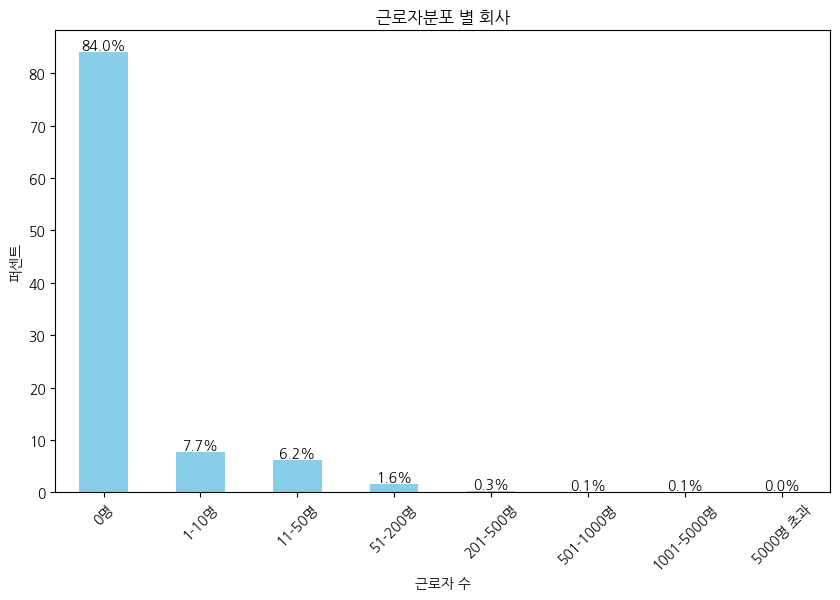

In [ ]:
# 퍼센트로 변환
employee_counts = company_df['employee_count'].value_counts(dropna=False)
employee_percentages = employee_counts / employee_counts.sum() * 100

# 막대그래프
ax = employee_percentages.plot(
    kind='bar',
    figsize=(10, 6),
    rot=45,
    color='skyblue'
)

# 타이틀 및 라벨
plt.title("근로자분포 별 회사")
plt.xlabel("근로자 수")
plt.ylabel("퍼센트")

# 각 막대 위에 퍼센트 표시
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{employee_percentages.iloc[i]:.1f}%",   # 소수점 1자리 퍼센트
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )

plt.show()

###### view_count 분포파악

In [ ]:
# view_count 컬럼 분포 확인
view_counts = company_df['view_count'].value_counts(dropna=False).sort_index()
view_counts.head(10)

,count
view_count,
0,1
1,240
2,239
3,235
4,218
5,157
6,138
7,135
8,96


In [ ]:
# 구간 정의
bins = [-float("inf"), 0, 50, 100, 300, 700, float("inf")]
labels = ["0 이하", "1~50", "51~100", "101~300", "301~700", "700 이상"]

# view_count 구간화
company_df['view_group'] = pd.cut(
    company_df['view_count'],
    bins=bins,
    labels=labels,
    right=True   # 구간 끝 포함 (예: 50 포함 → 1~50)
)

# 그룹별 빈도 및 비율
view_group_counts = company_df['view_group'].value_counts().sort_index()
view_group_percentages = view_group_counts / view_group_counts.sum() * 100

print(view_group_counts)
print(view_group_percentages.round(2))

view_group
0 이하           1
1~50        4789
51~100      3537
101~300     7632
301~700     7464
700 이상     18236
Name: count, dtype: int64
view_group
0 이하        0.00
1~50       11.50
51~100      8.49
101~300    18.32
301~700    17.92
700 이상     43.77
Name: count, dtype: float64


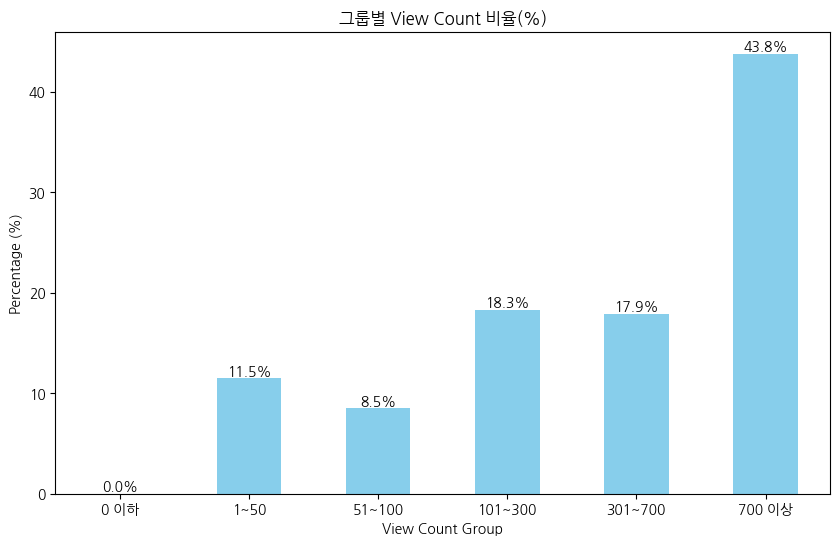

In [ ]:
ax = view_group_percentages.plot(
    kind='bar',
    figsize=(10, 6),
    color='skyblue',
    rot=0
)

plt.title("그룹별 View Count 비율(%)")
plt.xlabel("View Count Group")
plt.ylabel("Percentage (%)")

# 각 막대 위에 퍼센트 표시
for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{view_group_percentages.iloc[i]:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )

plt.show()

###### follow_count 분포파악

In [ ]:
# follow_count 컬럼 분포 확인
follow_counts = company_df['follow_count'].value_counts(dropna=False).sort_index()
follow_counts.head(10)

,count
follow_count,
0,23686
1,6168
2,1907
3,1206
4,961
5,685
6,532
7,466
8,364


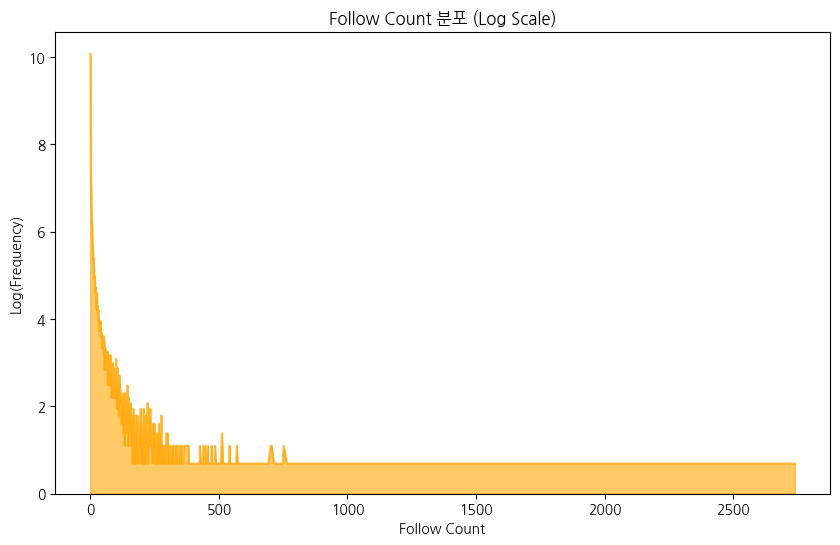

In [ ]:
# 0이 너무 많아서 나머지의 count자체가 너무 안보이는 문제 존재
# -> 로그스케일 사용해서 면적그래프 시각화함

import numpy as np

follow_counts_log = np.log1p(follow_counts)  # log(1+x), 0도 처리 가능

follow_counts_log.plot(
    kind='area',
    figsize=(10, 6),
    color='orange',
    alpha=0.6
)

plt.title("Follow Count 분포 (Log Scale)")
plt.xlabel("Follow Count")
plt.ylabel("Log(Frequency)")
plt.show()

##### company_funding 테이블 EDA


In [ ]:
companyfund_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9182 entries, 0 to 9181
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fund_date     9182 non-null   datetime64[ns]
 1   round_type    9182 non-null   object        
 2   raised        9182 non-null   int64         
 3   currency      9079 non-null   object        
 4   company_uuid  9182 non-null   object        
 5   fund_month    9182 non-null   int32         
 6   fund_year     9182 non-null   int32         
 7   raised_krw    9182 non-null   int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(3)
memory usage: 573.9+ KB


###### 월별 투자 건수 분포

In [ ]:
companyfund_df["fund_date"] = pd.to_datetime(companyfund_df["fund_date"])

#월 컬럼 생성 (YYYY-MM)
companyfund_df["fund_month"] = companyfund_df["fund_date"].dt.month

# 월별 투자 건수 집계
monthly_counts = companyfund_df.groupby("fund_month").size().reset_index(name="fund_count")


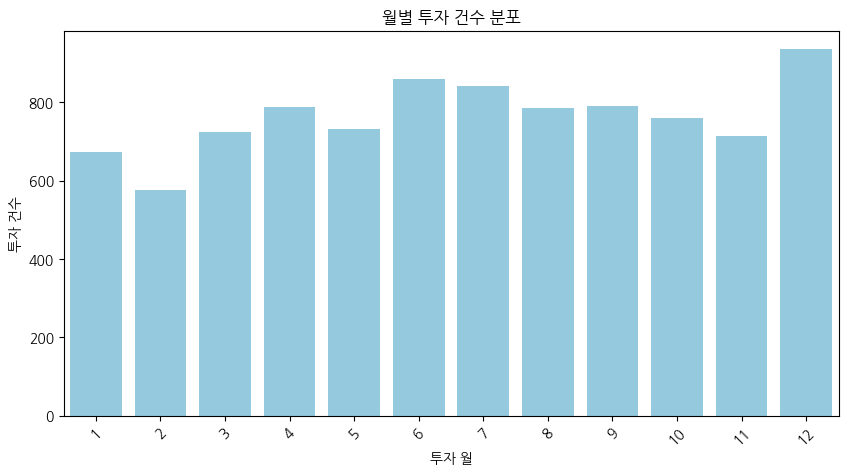

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="fund_month", y="fund_count", data=monthly_counts, color="skyblue")
plt.xlabel("투자 월")
plt.ylabel("투자 건수")
plt.title("월별 투자 건수 분포")
plt.xticks(rotation=45)
plt.show()

###### 연도별 투자 건수 분포

In [ ]:
# 연 컬럼 생성 (YYYY-MM)
companyfund_df["fund_year"] = companyfund_df["fund_date"].dt.year

# 연도별 투자 건수 집계
yearly_counts = companyfund_df.groupby("fund_year").size().reset_index(name="fund_count")

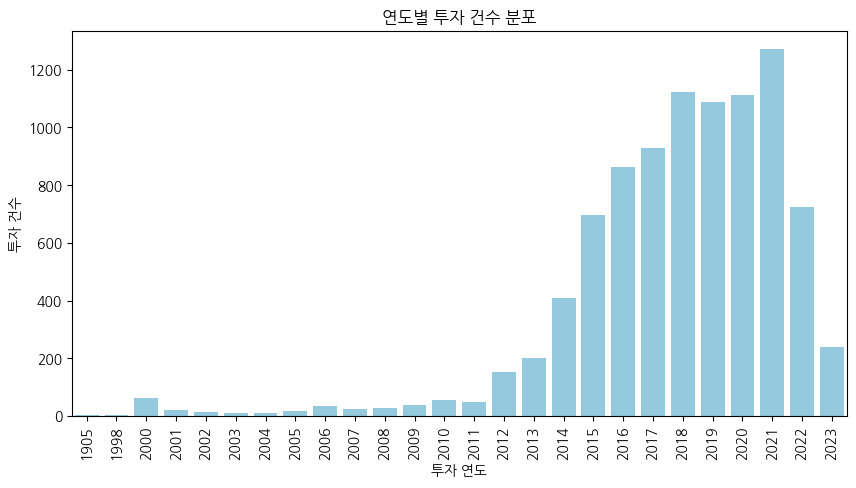

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="fund_year", y="fund_count", data=yearly_counts, color="skyblue")
plt.xlabel("투자 연도")
plt.ylabel("투자 건수")
plt.title("연도별 투자 건수 분포")
plt.xticks(rotation=90)
plt.show()

###### 투자단계별 투자금액

In [ ]:
companyfund_df["raised_krw"] = companyfund_df["raised"]

companyfund_df.loc[companyfund_df["currency"] == "USD", "raised_krw"] = \
    companyfund_df.loc[companyfund_df["currency"] == "USD", "raised"] * 1400
# 달러를 받은 경우 한국 돈으로 환전

In [ ]:
raised_sum = companyfund_df.groupby('round_type')['raised_krw'].sum().reset_index()
raised_sum = raised_sum.sort_values(by='raised_krw', ascending =False)
# 투자 단계별 금액 합치기

/tmp/ipython-input-2662948394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='round_type', y='raised_krw', data = raised_sum, errorbar = None, palette="Set2")


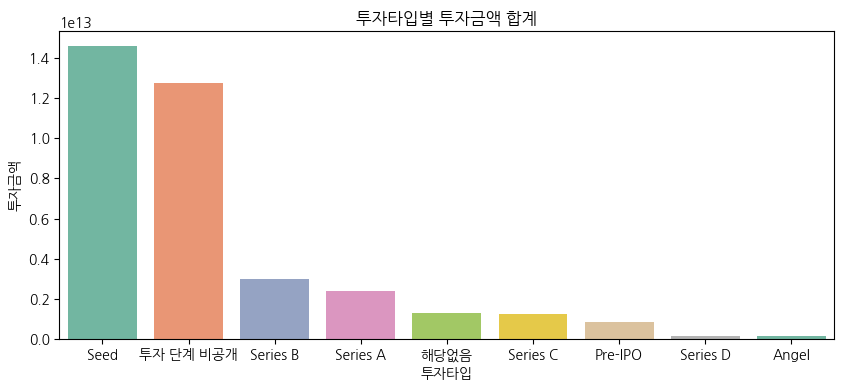

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(x='round_type', y='raised_krw', data = raised_sum, errorbar = None, palette="Set2")

plt.xlabel("투자타입")
plt.ylabel("투자금액")
plt.title("투자타입별 투자금액 합계")
plt.show()

##### job 테이블 EDA

In [ ]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133455 entries, 2 to 144246
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          133455 non-null  int64 
 1   cdate               133455 non-null  object
 2   mdate               133455 non-null  object
 3   job_field           133455 non-null  object
 4   career_type_string  133455 non-null  object
 5   start_date          133455 non-null  object
 6   end_date            113013 non-null  object
 7   allow_remote        133455 non-null  int64 
 8   can_show_salary     133455 non-null  int64 
 9   job_uuid            133455 non-null  object
 10  company_uuid        133455 non-null  object
 11  hiring_period       133455 non-null  object
 12  start_month         133455 non-null  int64 
 13  year                133455 non-null  int64 
 14  quarter             133455 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 16.3+ MB


###### 시각화 모듈화

###### 커스텀 plot

In [ ]:
def custom_barplot(df, x, y, title=None, xlabel=None, ylabel=None, hue=None, palette='viridis'):
  "custom_barplot(df명, x축,y축) 이렇게만 기본적으로만 작성하고 실행하면 스스로 작동"

  plt.figure(figsize=(12, 7))
  ax = sns.barplot(data=df, x=x, y=y, hue=hue, palette=palette)
  for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)
  # 제목 및 라벨 설정 (입력값이 있을 경우에만)
  if title:
    plt.title(title, fontsize=16)
  else:
    plt.title(f'{y} by {x}', fontsize=16)

  if xlabel:
    plt.xlabel(xlabel, fontsize=12)
  else:
    plt.xlabel(x, fontsize=12)

  if ylabel:
    plt.ylabel(ylabel, fontsize=12)
  else:
    plt.ylabel(y, fontsize=12)

  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
## 커스텀 Lineplot

In [ ]:
def custom_lineplot(df, x, y, style=None, palette='tab10', title=None, xlabel=None, ylabel=None, hue=None):
  "custom_lineplot(df명, x축,y축) 이렇게만 기본적으로만 작성하고 실행하면 스스로 작동"

  plt.figure(figsize=(12, 7))
  sns.lineplot(data=df, x=x, y=y, hue=hue, style=style, palette=palette, marker='o')

  # 제목 및 라벨 설정
  if title:
    plt.title(title, fontsize=16)
  else:
    plt.title(f'Trend of {y} over {x}', fontsize=16)

  if xlabel:
    plt.xlabel(xlabel, fontsize=12)
  else:
    plt.xlabel(x, fontsize=12)

  if ylabel:
    plt.ylabel(ylabel, fontsize=12)
  else:
    plt.ylabel(y, fontsize=12)

  plt.xticks(rotation=45)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.tight_layout()
  plt.show()

###### 전처리

In [ ]:
# 가장먼저 상시인지 채용시 종료인지, 기간이 있는지를 열을 만들자
# 구분해 낼수 있는 함수를 먼저 만든 후 적용

In [ ]:
def hiring_period(date_df):
  start_is_na = pd.isna(date_df['start_date'])
  end_is_na = pd.isna(date_df['end_date'])
  if start_is_na and end_is_na:
    return '상시채용'
  elif not start_is_na and end_is_na:
    return '채용시종료'
  else:
    return '기간채용'


job_df['hiring_period'] = job_df.apply(hiring_period, axis=1)


In [ ]:
# 이제 빈거 채워보자(시작 날짜만 필요해서 시작날짜만 채워보자)
# 공고를 등록한 날짜로 시작날짜를 정했다.

job_df['start_date'] = job_df['start_date'].fillna(job_df['cdate'])

# errors='coerce'를 추가하여 처리 불가능한 날짜를 NaT로 바꿉니다.
job_df['start_month'] = pd.to_datetime(job_df['start_date'], format='mixed', errors='coerce').dt.month


In [ ]:
# 0001-01-01 이라는 start-date가 존재 결측치처리

job_df['start_month'].isna().sum()
job_df.dropna(subset=['start_month'], inplace=True)

# 제거 후, month 컬럼은 NaN 때문에 float(실수) 형태가 되어 있습니다.
# 이를 다시 int(정수) 형태로 깔끔하게 바꿔줍니다.
job_df['start_month'] = job_df['start_month'].astype(int)
job_df['start_month'].isna().sum()

np.int64(0)

In [ ]:
job_ids = set(job_df['company_uuid'])
company_ids = set(company_df['company_uuid'])

unmatched_ids = job_ids - company_ids

In [ ]:
# 1. 데이터 필터링하여 복사본 생성
not_job = job_df[~job_df['company_uuid'].isin(unmatched_ids)].copy()

# 2. 'not_job'의 'start_date'를 datetime으로 변환 (이 부분은 올바르게 작성하셨습니다)
not_job['start_date'] = pd.to_datetime(not_job['start_date'], format='mixed')

# 3. datetime으로 변환된 'not_job'의 'start_date'를 사용하여 연도와 분기 추출
not_job['year'] = not_job['start_date'].dt.year
not_job['quarter'] = not_job['start_date'].dt.quarter

###### 채용 기간별 모집 공고 수

/tmp/ipython-input-2056163807.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, hue=hue, palette=palette)


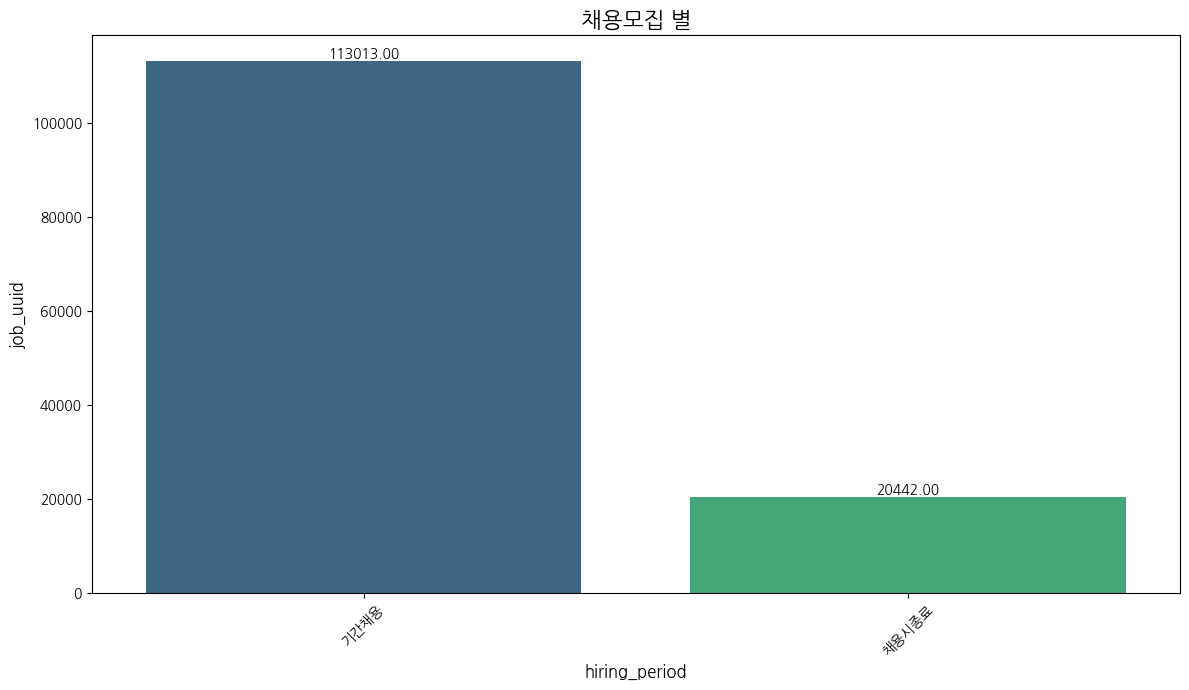

In [ ]:
hiring_period_group = job_df.groupby('hiring_period').count()
custom_barplot(hiring_period_group, 'hiring_period', 'job_uuid','채용모집 별')

/tmp/ipython-input-2056163807.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, hue=hue, palette=palette)


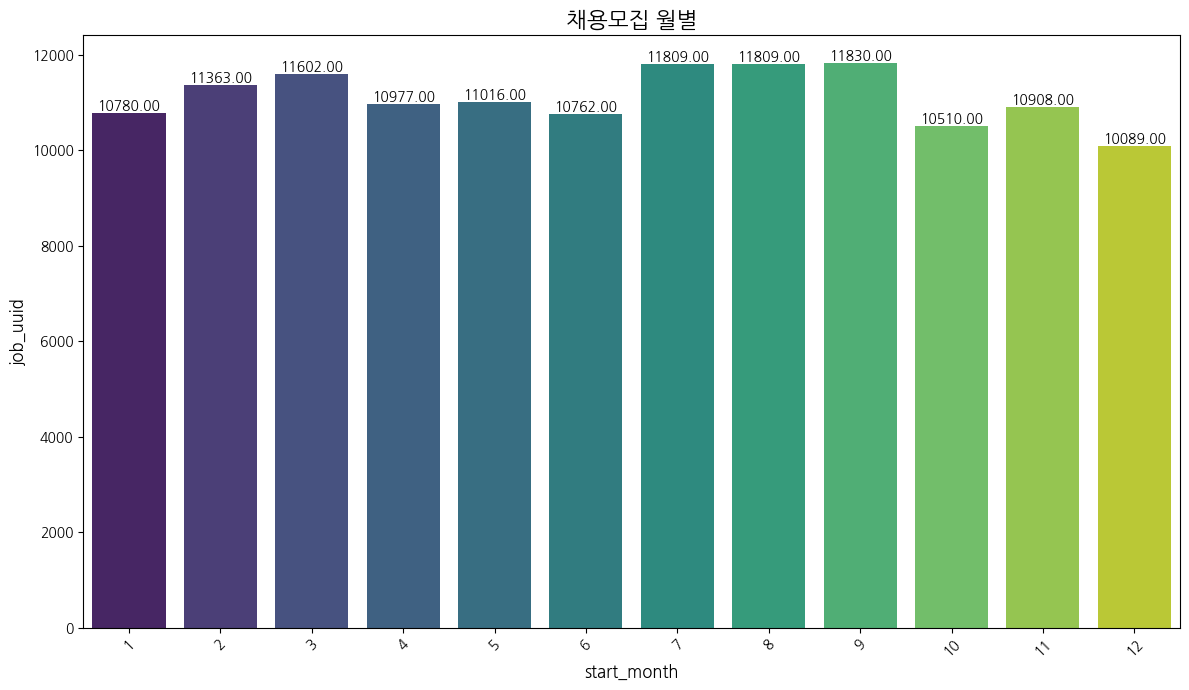

In [ ]:
job_month_group = job_df.groupby('start_month').count()
custom_barplot(job_month_group, 'start_month', 'job_uuid','채용모집 월별')

##### application_df 테이블 EDA

In [ ]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340730 entries, 0 to 340729
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   cdate             340730 non-null  object
 1   company_uuid      340730 non-null  object
 2   job_uuid          340730 non-null  object
 3   user_uuid         340730 non-null  object
 4   application_uuid  340730 non-null  object
dtypes: object(5)
memory usage: 15.6+ MB


In [ ]:
import pandas as pd
import numpy as np
import re
# 이걸 하는 이유는 aplication의 csv의 경우 cdate열이 오류인건지 cdate의 형식이 이상하게 적용되어져서 datetime을 그냥 넣을 경우 1번 index의 형식을 보고 자동으로 나머지 열은 결측치 처리를 해버리기 떄문이다.
# 또한 이상하게 형식이 안맞기때문 어떤 것은 AM / PM이런식의 형식이 있는 걸로 파악되기에 그런걸 한번에 맞추기 위함

def normalize_datetime_series_v2(s: pd.Series, assume_tz='Asia/Seoul') -> pd.Series:
    s_str = s.astype(str).str.strip()

    # 오전/오후 -> AM/PM
    s_str = (
        s_str.str.replace(r'\s*오전\s*', ' AM ', regex=True)
              .str.replace(r'\s*오후\s*', ' PM ', regex=True)
              .str.replace('  ', ' ')
              .str.strip()
    )

    numeric = pd.to_numeric(s_str, errors='coerce')
    out = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')

    # 엑셀 직렬일
    excel_mask = numeric.between(10000, 80000, inclusive='both')
    if excel_mask.any():
        out.loc[excel_mask] = pd.to_datetime(
            numeric.loc[excel_mask], unit='D', origin='1899-12-30', errors='coerce'
        )

    # 에포크
    int_like = s_str.str.fullmatch(r'[+-]?\d+')
    if int_like.any():
        ints = s_str.loc[int_like]
        lens = ints.str.len()
        sec_mask = lens.eq(10)
        ms_mask = lens.eq(13)
        us_mask = lens.eq(16)

        if sec_mask.any():
            out.loc[sec_mask.index[sec_mask]] = pd.to_datetime(ints.loc[sec_mask], unit='s', errors='coerce')
        if ms_mask.any():
            out.loc[ms_mask.index[ms_mask]] = pd.to_datetime(ints.loc[ms_mask], unit='ms', errors='coerce')
        if us_mask.any():
            out.loc[us_mask.index[us_mask]] = pd.to_datetime(ints.loc[us_mask], unit='us', errors='coerce')

    # 일반 문자열 + 마이크로초 포함 문자열 (%f)
    still_na = out.isna()
    if still_na.any():
        # 1차: 일반 포맷
        out.loc[still_na] = pd.to_datetime(s_str.loc[still_na], errors='coerce', infer_datetime_format=True)

        # 2차: 여전히 NaT인 경우, 마이크로초 포맷 명시
        second_try = out.isna()
        if second_try.any():
            out.loc[second_try] = pd.to_datetime(
                s_str.loc[second_try], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce'
            )

    # 타임존 통일
    if assume_tz:
        as_obj = out.astype('object')
        def _ensure_tz(x):
            if pd.isna(x):
                return pd.NaT
            if isinstance(x, pd.Timestamp):
                return x.tz_localize(assume_tz) if x.tz is None else x.tz_convert(assume_tz)
            return pd.NaT
        as_obj = as_obj.map(_ensure_tz)
        out = pd.to_datetime(as_obj)

    return out

# 적용
df = pd.read_csv("/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/채용플랫폼(로그없음)/Application.csv", dtype={'cdate': 'string'})
df['cdate_kst'] = normalize_datetime_series_v2(df['cdate'])

# 결과 확인
print(df[['cdate', 'cdate_kst']].head(15))
print("결측치 개수:", df['cdate_kst'].isna().sum())


/tmp/ipython-input-1436290100.py:48: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  out.loc[still_na] = pd.to_datetime(s_str.loc[still_na], errors='coerce', infer_datetime_format=True)


                         cdate                        cdate_kst
0          2017-02-25 23:45:01        2017-02-25 23:45:01+09:00
1   2020-11-23 14:46:07.329731 2020-11-23 14:46:07.329731+09:00
2   2017-10-28 22:30:10.631568 2017-10-28 22:30:10.631568+09:00
3   2017-07-03 17:40:05.317255 2017-07-03 17:40:05.317255+09:00
4          2017-02-10 10:53:39        2017-02-10 10:53:39+09:00
5          2017-01-21 22:25:37        2017-01-21 22:25:37+09:00
6          2017-02-10 17:02:53        2017-02-10 17:02:53+09:00
7          2017-04-05 19:11:49        2017-04-05 19:11:49+09:00
8          2017-04-05 19:19:52        2017-04-05 19:19:52+09:00
9          2017-04-06 20:08:54        2017-04-06 20:08:54+09:00
10         2017-04-25 22:01:03        2017-04-25 22:01:03+09:00
11         2017-05-12 20:15:29        2017-05-12 20:15:29+09:00
12  2019-06-09 12:06:23.268113 2019-06-09 12:06:23.268113+09:00
13         2017-03-08 22:17:04        2017-03-08 22:17:04+09:00
14  2019-06-09 12:01:15.512772 2019-06-0

###### 연도별/월별 지원으로 알아보는 채용시즌

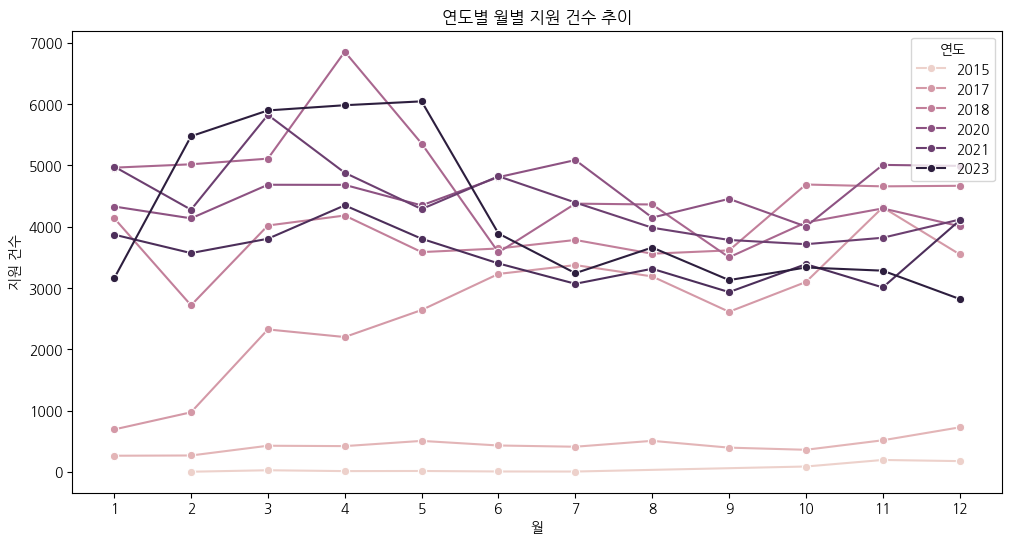

In [ ]:


# 연도, 월 추출
df['year'] = df['cdate_kst'].dt.year
df['month'] = df['cdate_kst'].dt.month

# 연도-월별 지원 건수 집계
monthly_app = df.groupby(['year','month']).size().reset_index(name='count')

# 시각화
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_app, x='month', y='count', hue='year', marker='o')

plt.title("연도별 월별 지원 건수 추이")
plt.xlabel("월")
plt.ylabel("지원 건수")
plt.xticks(range(1,13))
plt.legend(title="연도")
plt.show()

In [ ]:
#### 요일별로 알아보는 지원 건

/tmp/ipython-input-610434600.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_app.index, y=weekday_app.values, palette="viridis")


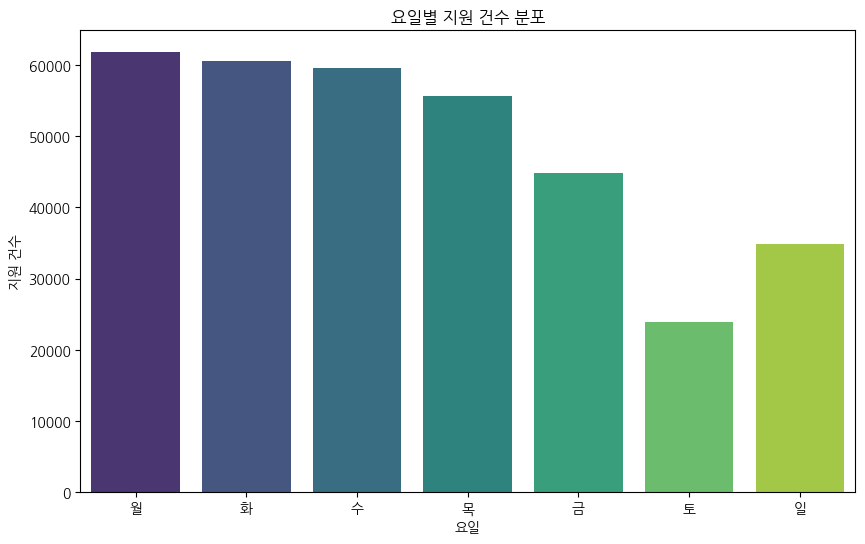

In [ ]:
# 요일 컬럼 생성 (0=월요일 ~ 6=일요일)
df['weekday'] = df['cdate_kst'].dt.dayofweek

# 요일 이름 매핑
weekday_map = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
df['weekday_name'] = df['weekday'].map(weekday_map)

# 요일별 지원 건수 집계
weekday_app = df['weekday_name'].value_counts().reindex(['월','화','수','목','금','토','일'])

# 시각화
plt.figure(figsize=(10,6))
sns.barplot(x=weekday_app.index, y=weekday_app.values, palette="viridis")

plt.title("요일별 지원 건수 분포")
plt.xlabel("요일")
plt.ylabel("지원 건수")
plt.show()

In [ ]:
# 월요일~수요일: 지원이 가장 많음
# 목,금요일: 점차 감소
# 주말: 지원 건수가 감소
# 구직자 -> 주중 초반 활발
# 기업 입장 -> 주중 초반 공고 업로드,광고 노출이 효과적으로 보임

###### 지원 쏠림 현상

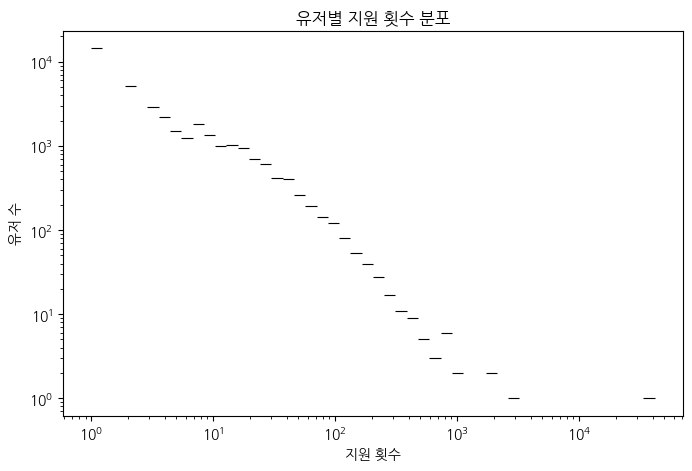

In [ ]:
# 유저별 지원 횟수
user_apps = df['user_uuid'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(user_apps, bins=50, log_scale=(True, True))
plt.title("유저별 지원 횟수 분포")
plt.xlabel("지원 횟수")
plt.ylabel("유저 수")
plt.show()

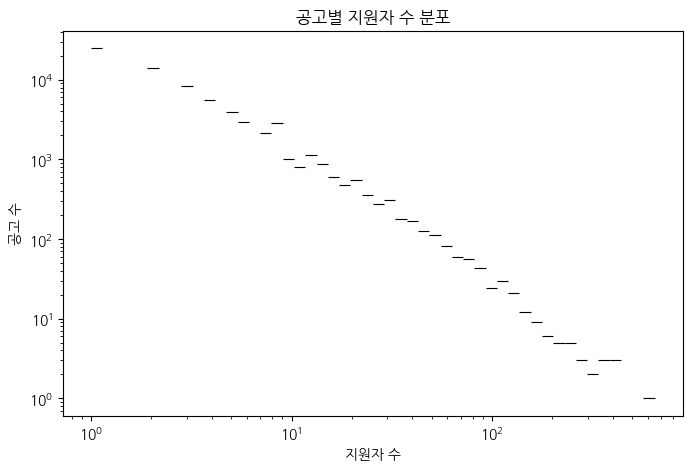

In [ ]:
# 공고별 지원자 수
job_apps = df['job_uuid'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(job_apps, bins=50, log_scale=(True, True))
plt.title("공고별 지원자 수 분포")
plt.xlabel("지원자 수")
plt.ylabel("공고 수")
plt.show()

In [ ]:
# 많은 유저, 공고가 소규모 활동을 차지 → 소수의 헤비 지원자가 전체 지원량을 끌어올린다.
# 일부 유저, 공고가 과도한 활동량·지원자 수를 차지 → 소수 인기 공고에 지원이 쏠림 현상

In [ ]:
# 유저관점 -> 대부분은 작게 지원 → 이탈 가능성 높아 보임
# 헤비지원자를 적극 구직자로 세분화 할수있을까?
# 공고관점 -> 대부분 공고는 지원자 부족, 일부 공고는 지원자 많음
# 균형있는 노출이 가능할까?

###### 상위 5개 기업의 지원자 쏠림

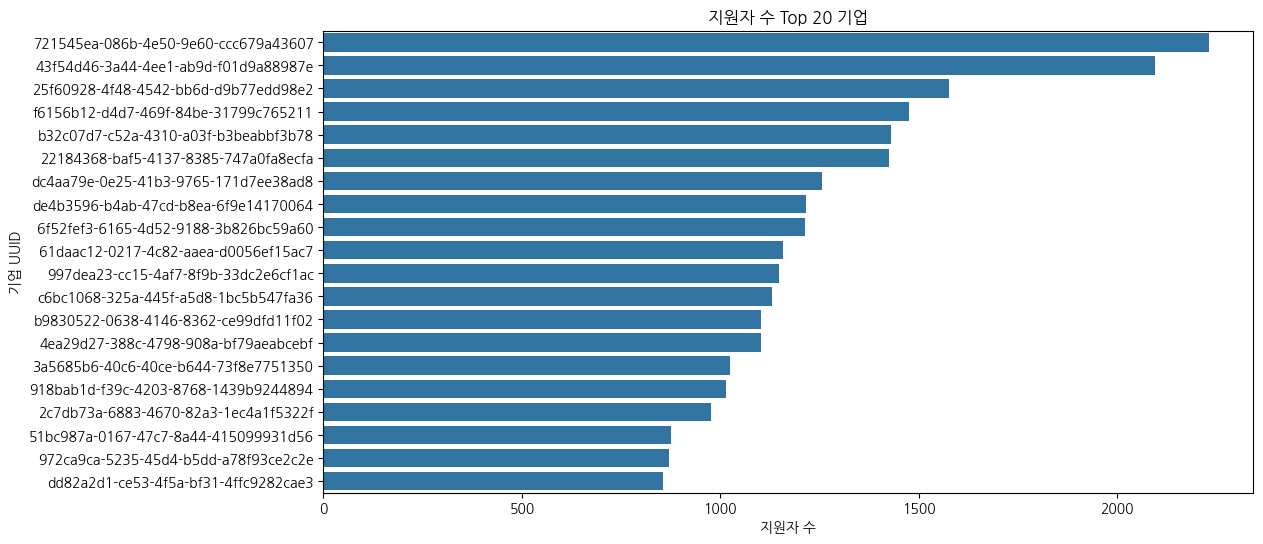

In [ ]:
company_apps = df['company_uuid'].value_counts()

# 기업별 지원자 수 상위 20
top20_companies = company_apps.head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top20_companies.values, y=top20_companies.index)
plt.title("지원자 수 Top 20 기업")
plt.xlabel("지원자 수")
plt.ylabel("기업 UUID")
plt.show()

###### 기업대 사람의 지원자 매칭이 이상하다

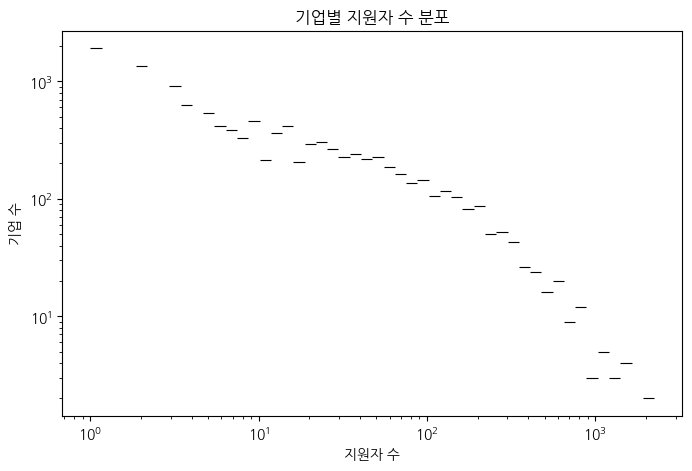

In [ ]:
# 기업별 지원자 수 분포 전체
plt.figure(figsize=(8,5))
sns.histplot(company_apps, bins=50, log_scale=(True, True))
plt.title("기업별 지원자 수 분포")
plt.xlabel("지원자 수")
plt.ylabel("기업 수")
plt.show()

###### 시간대별로 지원 건수의 차이가 있을까?

/tmp/ipython-input-1806444056.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_app.index, y=hourly_app.values, palette="magma")


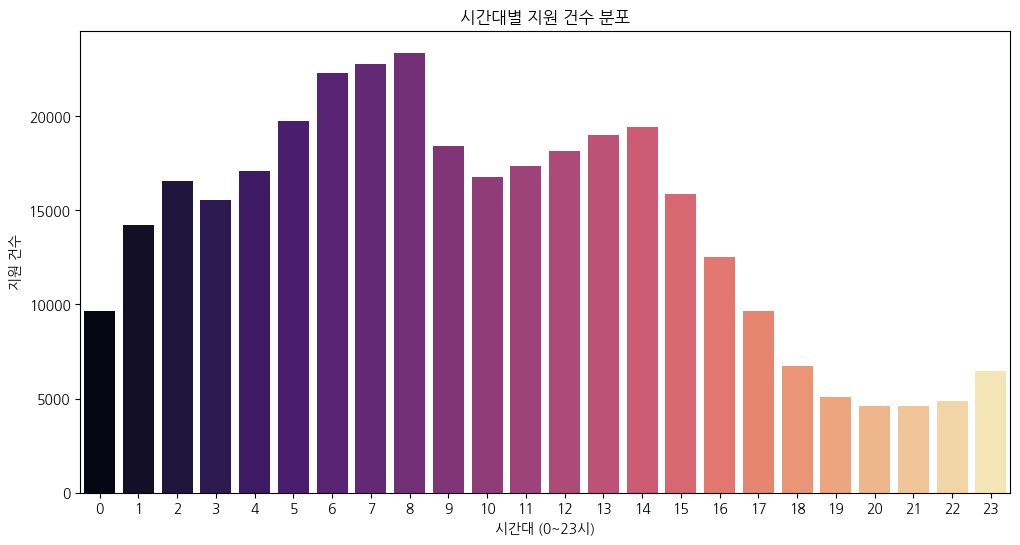

In [ ]:
# 시간(hour) 컬럼 생성
df['hour'] = df['cdate_kst'].dt.hour

# 시간대별 지원 건수 집계
hourly_app = df['hour'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12,6))
sns.barplot(x=hourly_app.index, y=hourly_app.values, palette="magma")

plt.title("시간대별 지원 건수 분포")
plt.xlabel("시간대 (0~23시)")
plt.ylabel("지원 건수")
plt.xticks(range(0,24))
plt.show()

###### 지원건수로 나눠보는 유저의 세그먼트

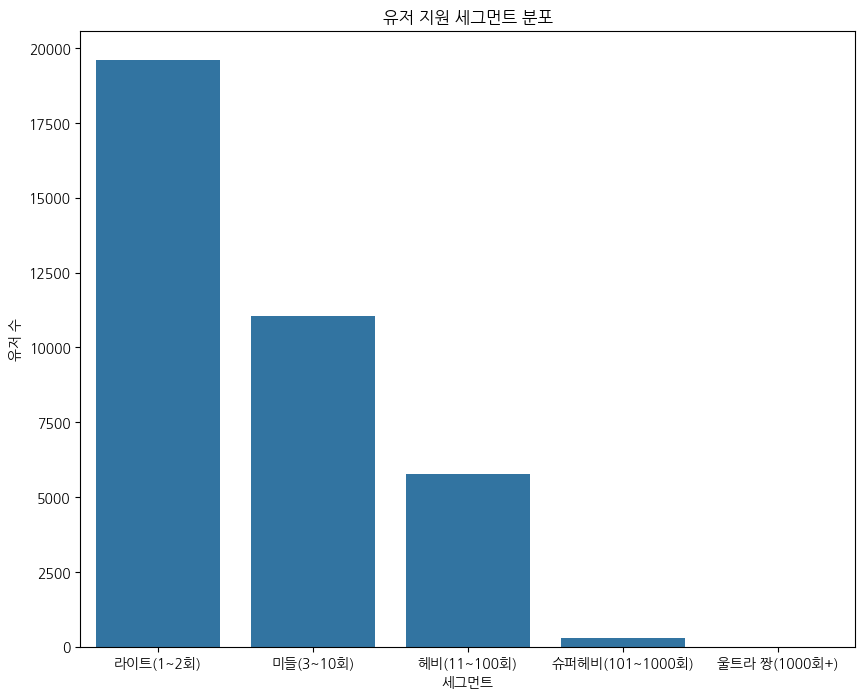

In [ ]:
user_apps = df['user_uuid'].value_counts()
segments = pd.cut(user_apps, bins=[0,2,10,100,1000,float("inf")],
                  labels=["라이트(1~2회)","미들(3~10회)","헤비(11~100회)","슈퍼헤비(101~1000회)","울트라 짱(1000회+)"])
seg_counts = segments.value_counts().sort_index()

plt.figure(figsize=(10,8))
sns.barplot(x=seg_counts.index, y=seg_counts.values)
plt.title("유저 지원 세그먼트 분포")
plt.xlabel("세그먼트")
plt.ylabel("유저 수")
plt.show()

##### jobbookmark 테이블 EDA

In [ ]:
jobbookmark_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413866 entries, 0 to 413865
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cdate      413866 non-null  object
 1   job_uuid   413866 non-null  object
 2   user_uuid  413866 non-null  object
dtypes: object(3)
memory usage: 12.6+ MB


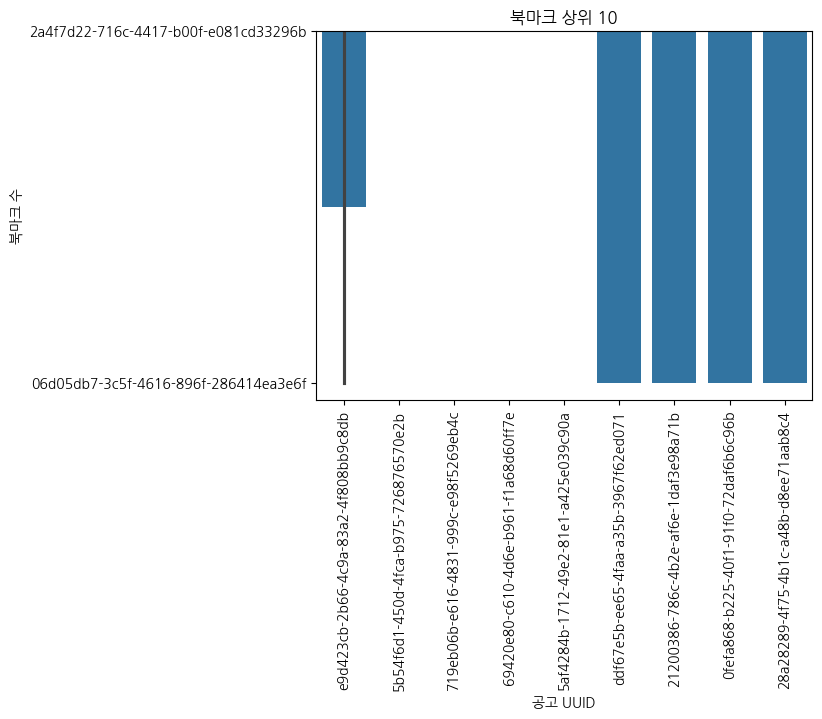

In [ ]:
bookmarked_job_10 = jobbookmark_df.head(10)

sns.barplot(data = bookmarked_job_10, x = 'job_uuid', y = 'user_uuid')
plt.title('북마크 상위 10')
plt.xlabel('공고 UUID')
plt.ylabel('북마크 수')
plt.xticks(rotation = 90)
plt.show()

#### 테이블 join하여 EDA

##### company + job EDA

In [ ]:
company_job_df = pd.merge(job_df,company_df, on='company_uuid', how='left')

###### 공고수 와 회사조회수 관계

In [ ]:
# 1. 회사별 집계
company_summary = (
    company_job_df
    .groupby("company_uuid")
    .agg(
        job_count=("job_uuid", "count"),      # 공고 수
        total_views=("view_count", "sum"),    # 총 조회수
        total_follows=("follow_count", "sum") # 총 팔로우 수
    )
    .reset_index()
)

In [ ]:
company_summary["views_per_job"] = (
    company_summary["total_views"] / company_summary["job_count"]
)

###### 공고 수와 회사정보 조회수

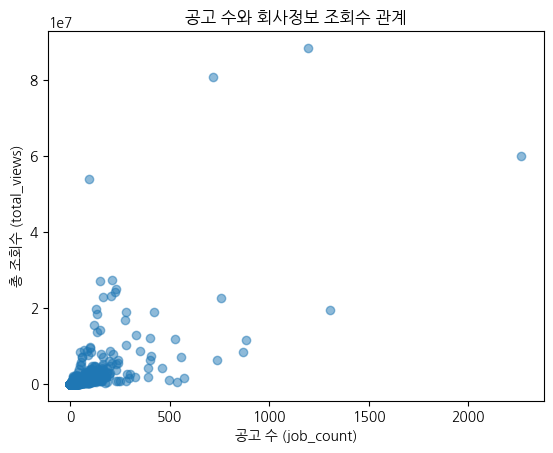

In [ ]:

plt.scatter(company_summary["job_count"], company_summary["total_views"], alpha=0.5)
plt.xlabel("공고 수 (job_count)")
plt.ylabel("총 조회수 (total_views)")
plt.title("공고 수와 회사정보 조회수 관계")
plt.show()

###### 조회수와 팔로우 수

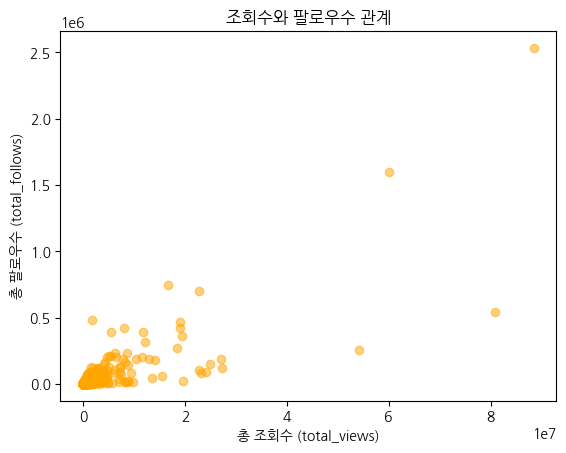

In [ ]:
# 4. 조회수 ↔ 팔로우수 관계
plt.scatter(company_summary["total_views"], company_summary["total_follows"], alpha=0.5, color="orange")
plt.xlabel("총 조회수 (total_views)")
plt.ylabel("총 팔로우수 (total_follows)")
plt.title("조회수와 팔로우수 관계")
plt.show()

In [ ]:
# 5. 상관계수 확인
correlation = company_summary[["job_count", "total_views", "total_follows"]].corr()
print("상관계수:")
print(correlation)

상관계수:
               job_count  total_views  total_follows
job_count       1.000000     0.684444       0.740911
total_views     0.684444     1.000000       0.811677
total_follows   0.740911     0.811677       1.000000


###### 회사 규모별 평균 공고수

employee_count
0명             6.324588
1-10명          7.436514
11-50명        18.056872
51-200명       34.701987
201-500명      43.443396
501-1000명     41.470588
1001-5000명    18.727273
5000명 초과       5.250000
Name: job_count, dtype: float64


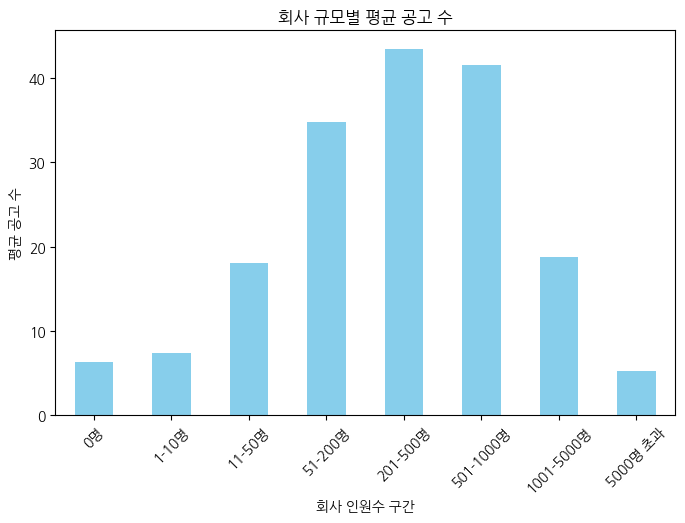

In [ ]:
# 1. 회사별 공고 수 계산
company_job_count = (
    company_job_df
    .groupby("company_uuid")
    .agg(
        employee_count=("employee_count", "first"),  # 회사 규모
        job_count=("job_uuid", "count")             # 회사별 공고 수
    )
    .reset_index()
)

# 2. 회사 규모 순서 정의 (문자열 기준)
size_order = ["0명", "1-10명", "11-50명", "51-200명", "201-500명",
              "501-1000명", "1001-5000명", "5000명 초과"]

# 3. 규모별 평균 공고 수 계산
avg_job_count_by_size = (
    company_job_count
    .groupby("employee_count")["job_count"]
    .mean()
    .reindex(size_order)
)

print(avg_job_count_by_size)

# 4. 시각화
avg_job_count_by_size.plot(kind="bar", figsize=(8,5), color="skyblue")
plt.ylabel("평균 공고 수")
plt.xlabel("회사 인원수 구간")
plt.title("회사 규모별 평균 공고 수")
plt.xticks(rotation=45)
plt.show()

###### 회사 규모별 직무 다양성

In [ ]:
# 1. 회사별 직무 다양성 집계
company_roles = (
    company_job_df
    .groupby("company_uuid")
    .agg(
        employee_count=("employee_count", "first"),  # 같은 회사는 동일 범주
        job_field_count=("job_field", "nunique")     # 직무 개수
    )
    .reset_index()
)

In [ ]:
# 회사규모 순서 정의
size_order = ["0명", "1-10명", "11-50명", "51-200명", "201-500명",
              "501-1000명", "1001-5000명", "5000명 초과"]

diversity_by_size = (
    company_roles
    .groupby("employee_count")["job_field_count"]
    .mean()
    .reindex(size_order)  # 수동으로 정렬
)


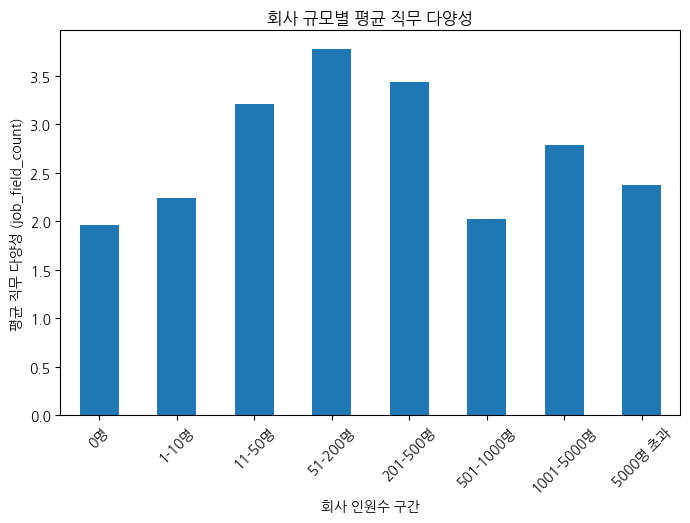

In [ ]:
# 3. 시각화
diversity_by_size.plot(kind="bar", figsize=(8,5))
plt.ylabel("평균 직무 다양성 (job_field_count)")
plt.xlabel("회사 인원수 구간")
plt.title("회사 규모별 평균 직무 다양성")
plt.xticks(rotation=45)
plt.show()

##### company + company_funding EDA

###### 팔로워 수별 투자받은 기업

In [ ]:
funded = companyfund_df.merge(company_df, on='company_uuid', how='left')
funded = funded.sort_values(by = 'raised_krw',ascending = False)


In [ ]:
# 투자금액 없는 회사
fund_zero = funded[funded['raised_krw'] == 0 ]
fund_zero.shape

(3857, 16)

In [ ]:
# 금액 0 회사 드랍
funded = funded[funded['raised_krw'] !=0].reset_index(drop=True)

In [ ]:
fund_follow_notnull = funded[funded["follow_count"].notnull()]

In [ ]:
fund_follow_cnt = fund_follow_notnull["follow_count"].value_counts().reset_index(name="count")
fund_follow_cnt = fund_follow_cnt.sort_values(by='follow_count', ascending = False).reset_index()
fund_follow_cnt = fund_follow_cnt.drop(columns=["index"])

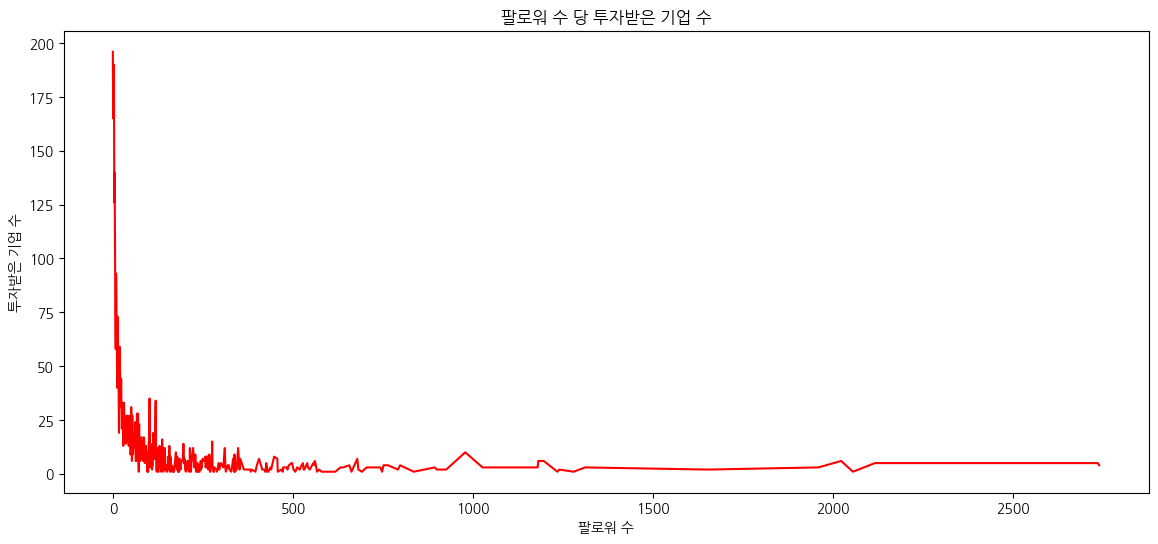

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(x='follow_count', y='count', data = fund_follow_cnt, errorbar = None, color = 'red')

plt.xlabel("팔로워 수")
plt.ylabel("투자받은 기업 수")
plt.title("팔로워 수 당 투자받은 기업 수")
plt.xticks(rotation = 0)
plt.show()

###### 투자유무에 따른 팔로워 수

In [ ]:
fund_zero_notnull = fund_zero[fund_zero["follow_count"].notnull()]

In [ ]:
fund_zero_follower = (
    fund_zero_notnull["follow_count"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "follow_count"})
    .sort_values(by="follow_count", ascending=True)
    .reset_index(drop=True)
)

In [ ]:
#이름통일
ff_zero = fund_zero_follower
ff_nonzero = fund_follow_cnt

# 그룹별 전체 수
total_zero = ff_zero["count"].sum()
total_nonzero = ff_nonzero["count"].sum()

# 비율 계산
ff_zero = ff_zero.assign(ratio_zero = ff_zero["count"] / total_zero)
ff_nonzero = ff_nonzero.assign(ratio_nonzero = ff_nonzero["count"] / total_nonzero)

# merge해서 비교표 생성
compare = pd.merge(
    ff_zero[["follow_count", "ratio_zero"]],
    ff_nonzero[["follow_count", "ratio_nonzero"]],
    on="follow_count",
    how="outer"
).fillna(0).sort_values("follow_count")

In [ ]:
#이름통일
ff_zero = fund_zero_follower
ff_nonzero = fund_follow_cnt

# 그룹별 전체 수
total_zero = ff_zero["count"].sum()
total_nonzero = ff_nonzero["count"].sum()

# 비율 계산
ff_zero = ff_zero.assign(ratio_zero = ff_zero["count"] / total_zero)
ff_nonzero = ff_nonzero.assign(ratio_nonzero = ff_nonzero["count"] / total_nonzero)

# merge해서 비교표 생성
compare = pd.merge(
    ff_zero[["follow_count", "ratio_zero"]],
    ff_nonzero[["follow_count", "ratio_nonzero"]],
    on="follow_count",
    how="outer"
).fillna(0).sort_values("follow_count")

In [ ]:
compare_filtered = compare[(compare["follow_count"] >= 0) & (compare["follow_count"] <= 50)]

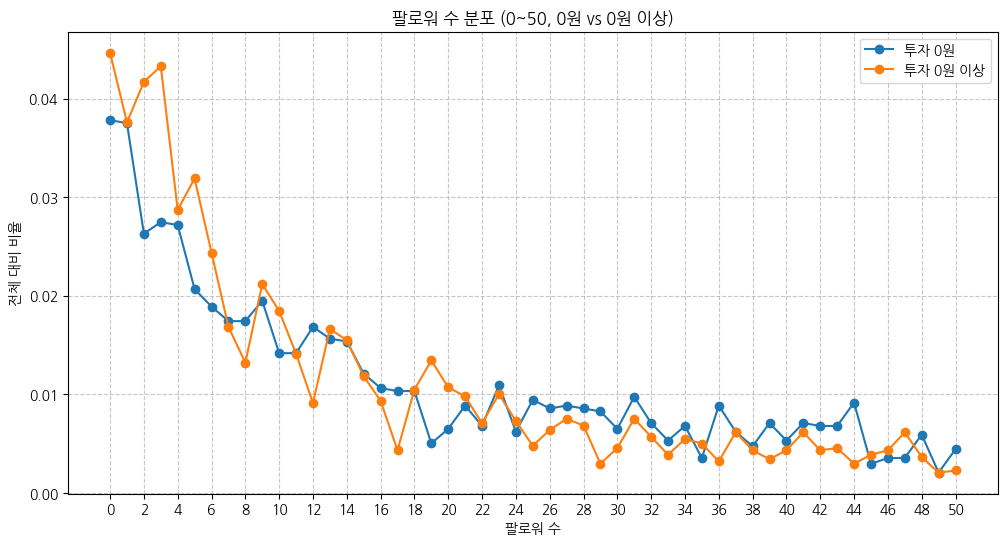

In [ ]:
x = compare_filtered["follow_count"]

plt.figure(figsize=(12,6))
plt.plot(x, compare_filtered["ratio_zero"], marker="o", label="투자 0원")
plt.plot(x, compare_filtered["ratio_nonzero"], marker="o", label="투자 0원 이상")

plt.xlabel("팔로워 수")
plt.ylabel("전체 대비 비율")
plt.title("팔로워 수 분포 (0~50, 0원 vs 0원 이상)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 51, 2))  # x축 눈금 2 단위
plt.show()


##### job + company_funding EDA

##### Job_BookMark + job EDA

In [ ]:
w = pd.merge(job_df, jobbookmark_df, on = 'job_uuid', how = 'inner')

In [ ]:
field_bookmark = w.groupby('job_field')[['user_uuid']].count().sort_values(by='user_uuid', ascending =False).reset_index()

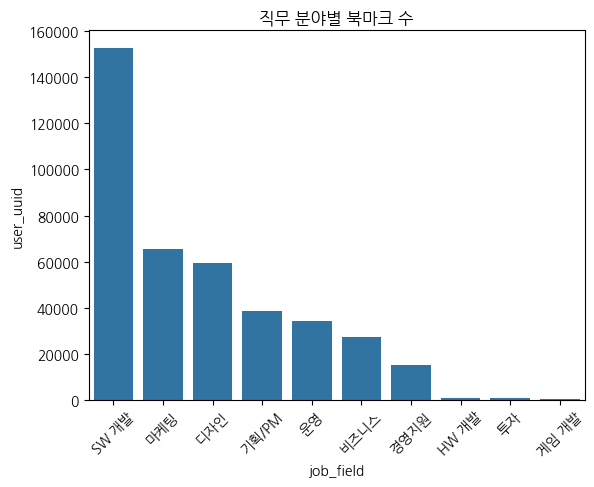

In [ ]:
sns.barplot(data = field_bookmark, x = 'job_field', y = 'user_uuid')
plt.xticks(rotation = 45)
plt.title("직무 분야별 북마크 수")
plt.show()

In [ ]:
career_type_bookmark = w.groupby('career_type_string')[['user_uuid']].count().sort_values(by='user_uuid', ascending =False).reset_index()

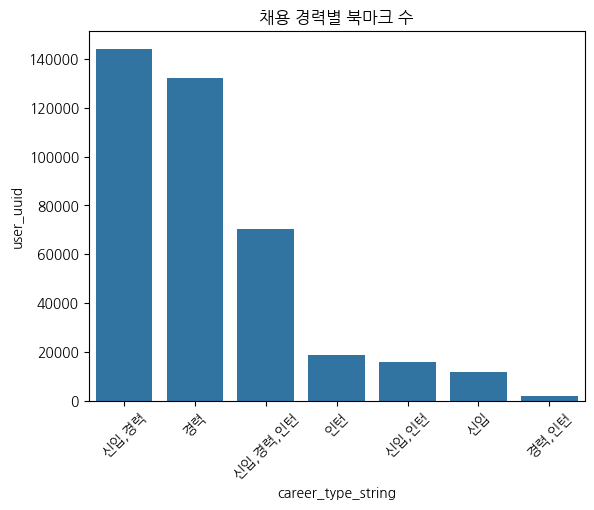

In [ ]:
sns.barplot(data = career_type_bookmark, x = 'career_type_string', y = 'user_uuid')
plt.xticks(rotation = 45)
plt.title("채용 경력별 북마크 수")
plt.show()

## 로그 EDA

#### 전환형 그룹 vs 탐색형 그룹 가설 검증

##### 가설1. 탐색형유저는 전환형유저보다 활동일수가 적을 것이다.

In [ ]:
# 각 그룹에서 사용자별 활동일수 계산
apply_days_per_user = (
    apply_group.groupby('user_uuid')['date']
    .nunique()  # 고유 날짜 수
)

non_apply_days_per_user = (
    non_apply_group.groupby('user_uuid')['date']
    .nunique()
)

# 사용자당 평균 활동일수 계산
apply_avg_days = apply_days_per_user.mean()
non_apply_avg_days = non_apply_days_per_user.mean()

print(f"전환형 유저 평균 활동일수: {apply_avg_days:.2f}일")
print(f"탐색형 유저 평균 활동일수: {non_apply_avg_days:.2f}일")

전환형 유저 평균 활동일수: 35.65일
탐색형 유저 평균 활동일수: 15.13일


/tmp/ipython-input-432538923.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_days_df, x='그룹', y='평균 활동일수', palette='Set2')


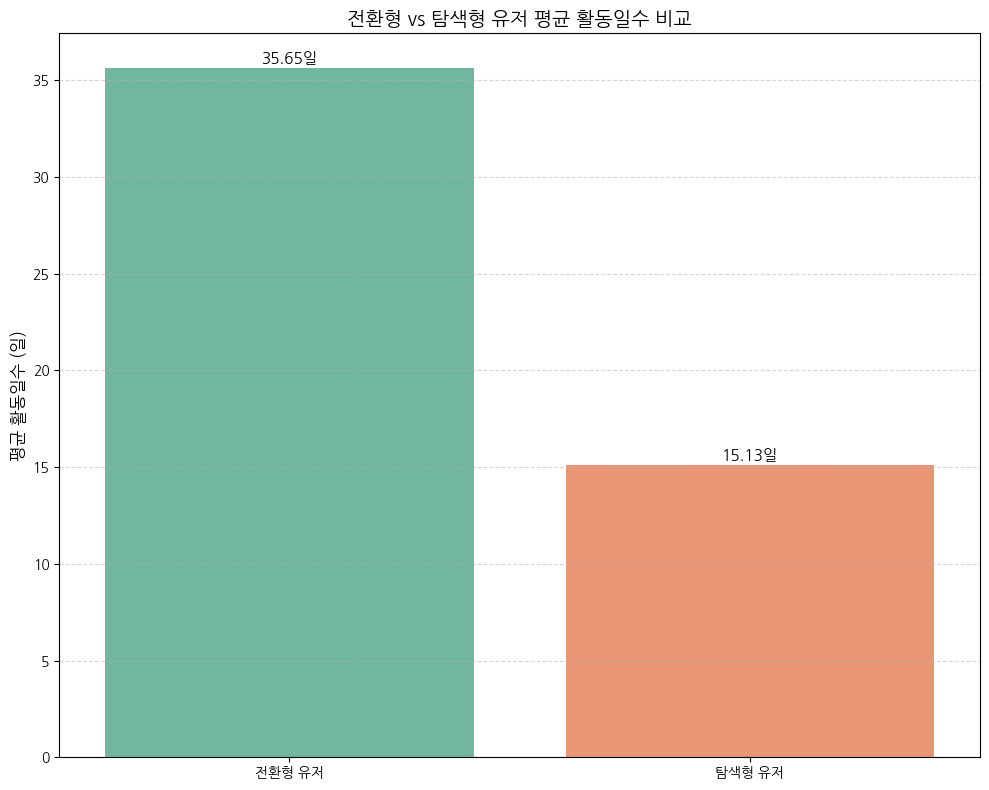

In [ ]:
# 데이터 준비
avg_days_df = pd.DataFrame({
    '그룹': ['전환형 유저', '탐색형 유저'],
    '평균 활동일수': [apply_avg_days, non_apply_avg_days]
})

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=avg_days_df, x='그룹', y='평균 활동일수', palette='Set2')

# 그래프 제목 및 축 라벨 설정
plt.title('전환형 vs 탐색형 유저 평균 활동일수 비교', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 활동일수 (일)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 수치 표시
for i, val in enumerate(avg_days_df['평균 활동일수']):
    plt.text(i, val + 0.1, f"{val:.2f}일", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

##### 가설2. 탐색형유저는 전환형유저보다 검색활동이 많을 것이다.

In [ ]:
# 1. 각 그룹에서 검색활동만 필터링
apply_search = apply_group[apply_group['URL'].str.contains('api/search', case=False, na=False)]
non_apply_search = non_apply_group[non_apply_group['URL'].str.contains('api/search', case=False, na=False)]

In [ ]:
# 2. 각 그룹에서 user_uuid별 검색활동 횟수 계산
apply_search_count = apply_search.groupby('user_uuid')['URL'].count()
non_apply_search_count = non_apply_search.groupby('user_uuid')['URL'].count()

In [ ]:
# 3. 사용자당 평균 검색활동 횟수 계산
apply_avg_search = apply_search_count.mean()
non_apply_avg_search = non_apply_search_count.mean()

print(f"전환형 유저 평균 검색활동 수: {apply_avg_search:.2f}회")
print(f"탐색형 유저 평균 검색활동 수: {non_apply_avg_search:.2f}회")

전환형 유저 평균 검색활동 수: 96.99회
탐색형 유저 평균 검색활동 수: 20.75회


/tmp/ipython-input-816086178.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_search_df, x='그룹', y='평균 검색활동 횟수', palette='Set3')


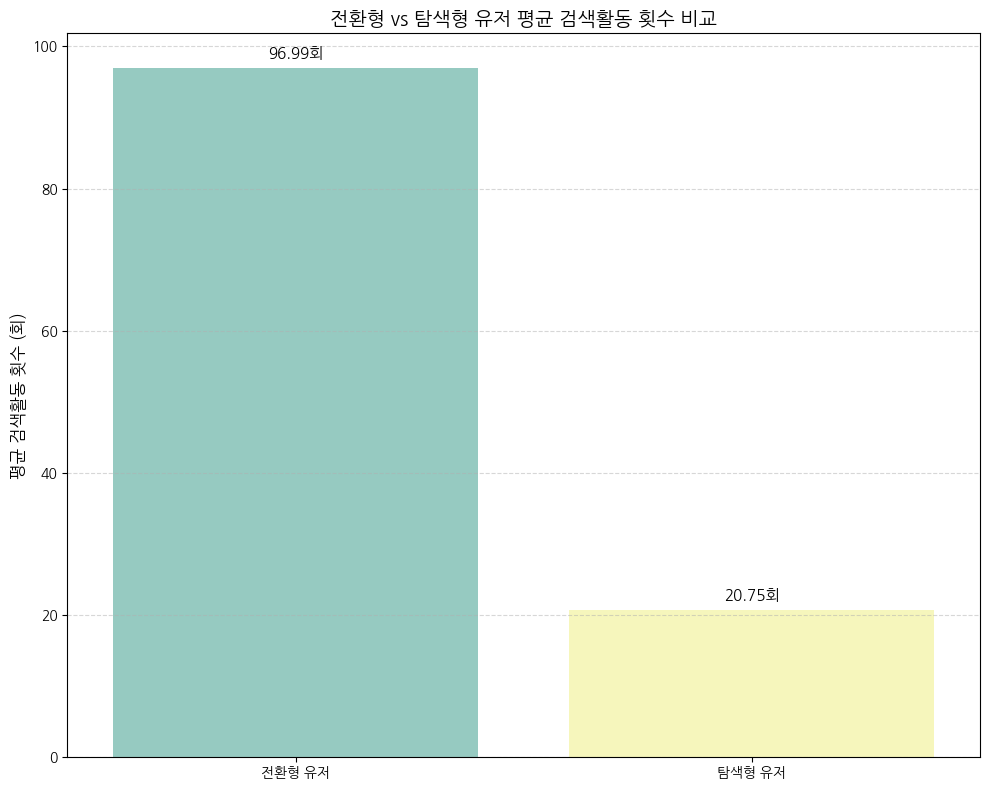

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
avg_search_df = pd.DataFrame({
    '그룹': ['전환형 유저', '탐색형 유저'],
    '평균 검색활동 횟수': [apply_avg_search, non_apply_avg_search]
})

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=avg_search_df, x='그룹', y='평균 검색활동 횟수', palette='Set3')

# 그래프 제목 및 축 라벨
plt.title('전환형 vs 탐색형 유저 평균 검색활동 횟수 비교', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 검색활동 횟수 (회)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위 수치 표시
for i, val in enumerate(avg_search_df['평균 검색활동 횟수']):
    plt.text(i, val +1,
             f"{val:.2f}회", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


##### 가설3. 탐색형유저는 전환형유저보다 이력서수정이 적을 것이다. (개인페이지 접속 적음)

In [ ]:
# 1. 각 그룹에서 '이력서 수정 활동'만 필터링
apply_resume = apply_group[apply_group['URL'].str.contains('api/users/id', case=False, na=False)]
non_apply_resume = non_apply_group[non_apply_group['URL'].str.contains('api/users/id', case=False, na=False)]

In [ ]:
# 2. 각 그룹에서 user_uuid별 이력서 수정 횟수 계산
apply_resume_count = apply_resume.groupby('user_uuid')['URL'].count()
non_apply_resume_count = non_apply_resume.groupby('user_uuid')['URL'].count()

In [ ]:
# 3. 사용자당 평균 이력서 수정 횟수 계산
apply_avg_resume = apply_resume_count.mean()
non_apply_avg_resume = non_apply_resume_count.mean()

print(f"전환형 유저 평균 이력서 수정 횟수: {apply_avg_resume:.2f}회")
print(f"탐색형 유저 평균 이력서 수정 횟수: {non_apply_avg_resume:.2f}회")

전환형 유저 평균 이력서 수정 횟수: 182.05회
탐색형 유저 평균 이력서 수정 횟수: 54.32회


/tmp/ipython-input-1545016464.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_resume_df, x='그룹', y='평균 이력서 수정 횟수', palette='pastel')


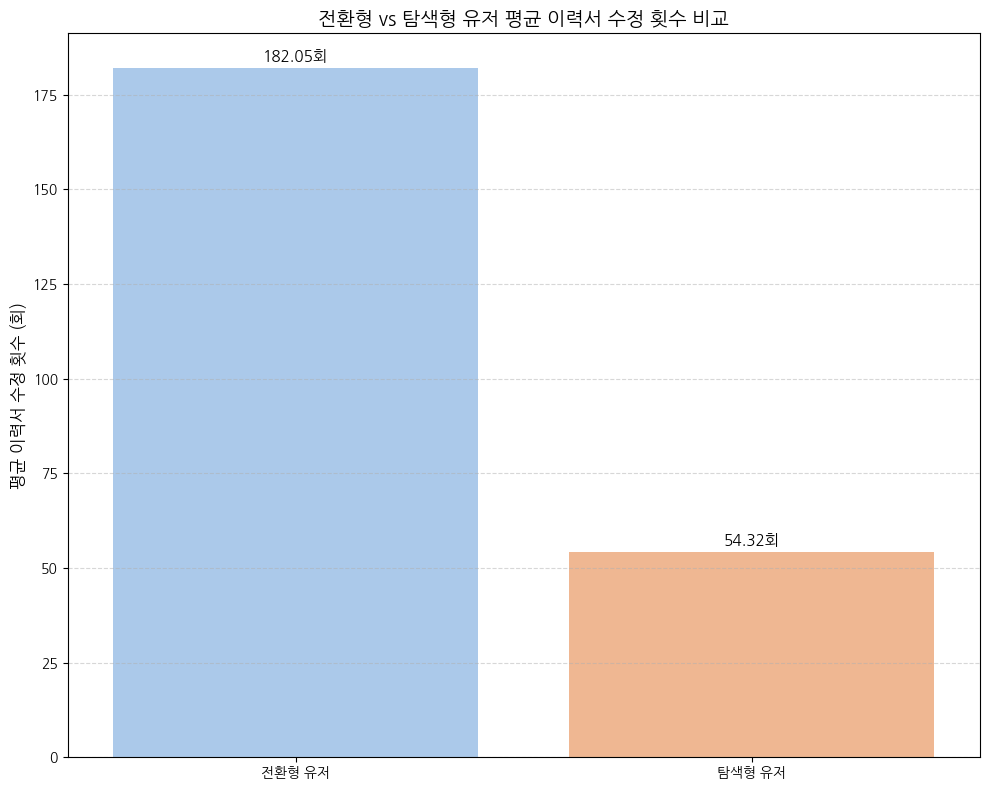

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
avg_resume_df = pd.DataFrame({
    '그룹': ['전환형 유저', '탐색형 유저'],
    '평균 이력서 수정 횟수': [apply_avg_resume, non_apply_avg_resume]
})

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=avg_resume_df, x='그룹', y='평균 이력서 수정 횟수', palette='pastel')

# 제목 및 축 설정
plt.title('전환형 vs 탐색형 유저 평균 이력서 수정 횟수 비교', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 이력서 수정 횟수 (회)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위 수치 표시
for i, val in enumerate(avg_resume_df['평균 이력서 수정 횟수']):
    plt.text(i, val +1,
             f"{val:.2f}회", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


##### 가설4. 탐색형유저는 전환형유저보다 공고클릭율(POST기준)이 높을 것이다.

###### 탐색형 과 전환형 클릭율 비교

In [ ]:
# 유저 단위로 보는 것과 전체양을 갯수로 보는 것의 관점의 차이가 있을수 있어서 나누어서 진행하였습니다.

target_path = 'api/jobs/job_title'

def calculate_click_rate(df):
    # 1) 해당 path를 방문한 사용자 집합
    clicked_users = df[df['path'] == target_path]['user_uuid'].unique()

    # 2) 전체 사용자 수 대비 클릭 사용자 비율
    total_users = df['user_uuid'].nunique()
    click_rate = len(clicked_users) / total_users if total_users > 0 else 0

    return click_rate, len(clicked_users), total_users

apply_rate, apply_clicked, apply_total = calculate_click_rate(apply_group)
non_apply_rate, non_apply_clicked, non_apply_total = calculate_click_rate(non_apply_group)

print(f"[전환형 그룹]   클릭율: {apply_rate:.2%}  ({apply_clicked}/{apply_total})")
print(f"[탐색형] 그룹] 클릭율: {non_apply_rate:.2%}  ({non_apply_clicked}/{non_apply_total})")


[전환형 그룹]   클릭율: 91.37%  (11397/12473)
[탐색형] 그룹] 클릭율: 76.00%  (4205/5533)


/tmp/ipython-input-3818542986.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=click_rate_df, x='그룹', y='클릭율(%)', palette='coolwarm')


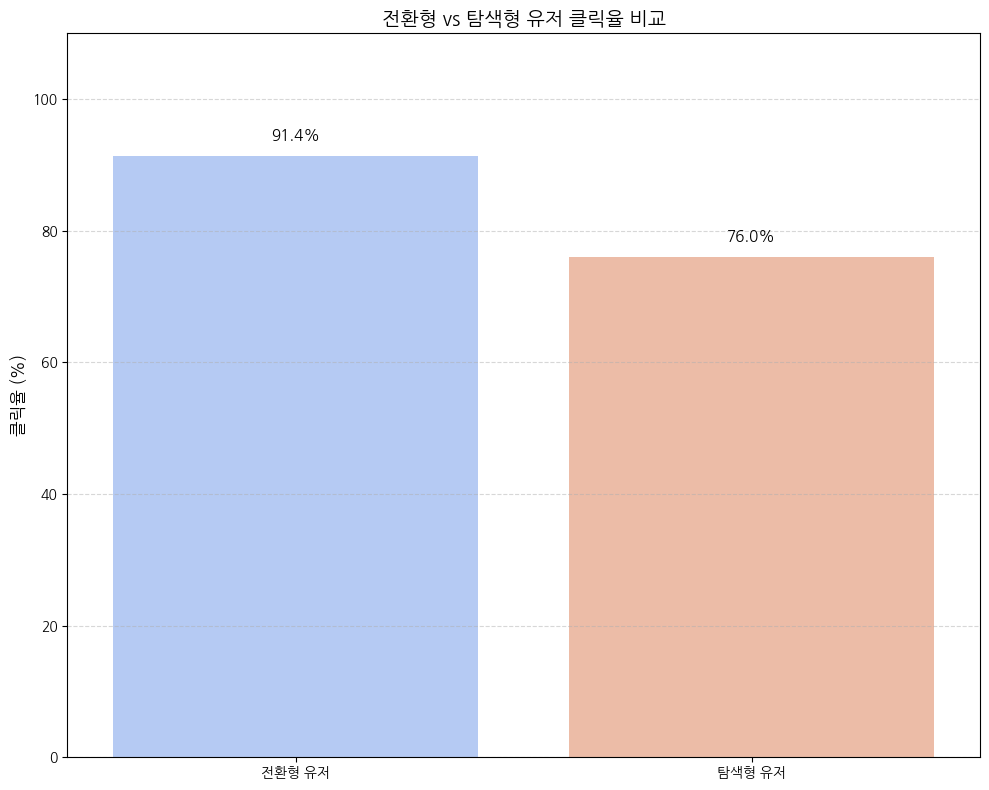

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
click_rate_df = pd.DataFrame({
    '그룹': ['전환형 유저', '탐색형 유저'],
    '클릭율(%)': [apply_rate * 100, non_apply_rate * 100]  # 비율을 퍼센트로 변환
})

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=click_rate_df, x='그룹', y='클릭율(%)', palette='coolwarm')

# 제목 및 축 설정
plt.title('전환형 vs 탐색형 유저 클릭율 비교', fontsize=14)
plt.xlabel('')
plt.ylabel('클릭율 (%)', fontsize=12)
plt.ylim(0, 110)  # 퍼센트 단위이므로 최대 100~110까지
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위 수치 표시
for i, val in enumerate(click_rate_df['클릭율(%)']):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

apply_clicked = 11397
apply_total = 12473

non_apply_clicked = 4205
non_apply_total = 5533

count = [apply_clicked, non_apply_clicked]
nobs = [apply_total, non_apply_total]

stat, p_value = proportions_ztest(count, nobs)

print(f"Z-Statistic: {stat:.4f}, p-value: {p_value:.50f}")

alpha = 0.05
if p_value < alpha:
    print("두 그룹의 클릭율 차이는 통계적으로 유의미합니다. (귀무가설 기각)")
else:
    print("클릭율 차이가 우연일 가능성이 높음 (귀무가설 채택)")


Z-Statistic: 27.9851, p-value: 0.00000000000000000000000000000000000000000000000000
두 그룹의 클릭율 차이는 통계적으로 유의미합니다. (귀무가설 기각)


###### 탐색형 과 전환형 클릭수 비교

In [ ]:
def calculate_click_count(df):
    return df[df['path'] == target_path].shape[0]

apply_click_count = calculate_click_count(apply_group)
non_apply_click_count = calculate_click_count(non_apply_group)

print(f"[전환형 그룹] 총 클릭수: {apply_click_count}")
print(f"[탐색형 그룹] 총 클릭수: {non_apply_click_count}")

[전환형 그룹] 총 클릭수: 1128772
[탐색형 그룹] 총 클릭수: 88296


##### 가설5. 탐색형유저는 전환형유저보다 동일날짜 마지막세션시간-첫세션시간(세션시간?체류시간?)이 더 짧을 것이다.

In [ ]:
import pandas as pd

def calculate_daily_session_duration(df):
    df['timestamp_kst'] = pd.to_datetime(df['timestamp_kst'])

    # user_uuid + date 단위로 그룹화
    session_stats = df.groupby(['user_uuid', 'date'])['timestamp_kst'].agg(['min', 'max']).reset_index()

    session_stats['duration'] = session_stats['max'] - session_stats['min']
    session_stats['duration_minutes'] = session_stats['duration'].dt.total_seconds() / 60

    return session_stats

apply_sessions = calculate_daily_session_duration(apply_group)
non_apply_sessions = calculate_daily_session_duration(non_apply_group)



In [ ]:
print("[전환형그룹] 평균 체류시간(분):", apply_sessions['duration_minutes'].mean())
print("[탐색형그룹] 평균 체류시간(분):", non_apply_sessions['duration_minutes'].mean())
print()
print("[전환형그룹] 중앙값 체류시간(분):", apply_sessions['duration_minutes'].median())
print("[탐색형그룹] 중앙값 체류시간(분):", non_apply_sessions['duration_minutes'].median())


[전환형그룹] 평균 체류시간(분): 169.32912397806896
[탐색형그룹] 평균 체류시간(분): 87.53027928601914

[전환형그룹] 중앙값 체류시간(분): 5.922371633333333
[탐색형그룹] 중앙값 체류시간(분): 1.4031180583333334


/tmp/ipython-input-1057546405.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_duration_df, x='그룹', y='평균 체류시간(분)', palette='YlOrBr')


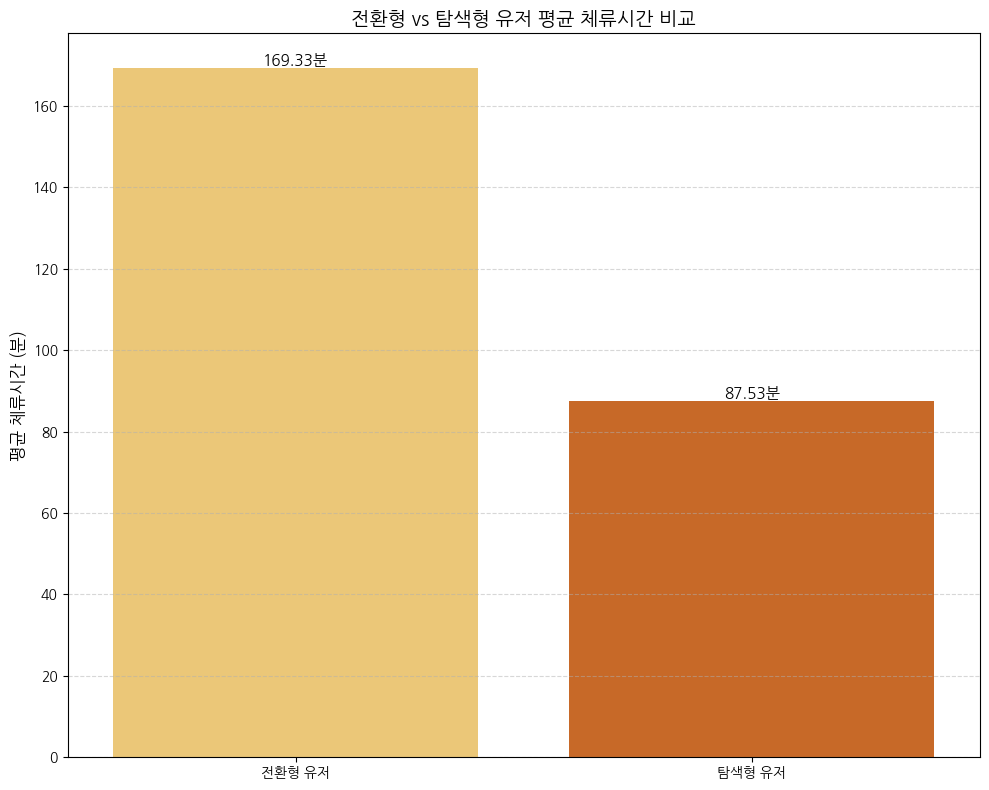

In [ ]:
# 평균 계산
apply_avg_duration = apply_sessions['duration_minutes'].mean()
non_apply_avg_duration = non_apply_sessions['duration_minutes'].mean()

# 데이터프레임 구성
avg_duration_df = pd.DataFrame({
    '그룹': ['전환형 유저', '탐색형 유저'],
    '평균 체류시간(분)': [apply_avg_duration, non_apply_avg_duration]
})

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=avg_duration_df, x='그룹', y='평균 체류시간(분)', palette='YlOrBr')

# 그래프 제목 및 축 설정
plt.title('전환형 vs 탐색형 유저 평균 체류시간 비교', fontsize=14)
plt.xlabel('')
plt.ylabel('평균 체류시간 (분)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위 수치 표시 (소수점 2자리)
for i, val in enumerate(avg_duration_df['평균 체류시간(분)']):
    plt.text(i, val,
             f"{val:.2f}분", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

##### 가설6. 탐색형유저는 전환형유저보다 주말/야간에 더 많이 접속할 것이다.

In [ ]:
# 주말인지 평일인지 / 시간대를 분류하는 함수를 만들어서 한번에 apply를 해서 사용하기 위한 함
def add_time_features(df):
    df['timestamp_kst'] = pd.to_datetime(df['timestamp_kst'])

    # 평일/주말 구분만 (월~금 = weekday / 토~일 = weekend)
    df['day_type'] = df['timestamp_kst'].dt.weekday.map(lambda x: 'weekend' if x >= 5 else 'weekday')

    # 시간대 분류 (이건 기존대로 사용)
    df['hour'] = df['timestamp_kst'].dt.hour

    def get_time_bucket(h):
        if 9 <= h < 18:
            return 'day'
        elif 18 <= h < 22:
            return 'evening'
        else:
            return 'night'

    df['time_bucket'] = df['hour'].apply(get_time_bucket)

    return df

apply_group = add_time_features(apply_group)
non_apply_group = add_time_features(non_apply_group)

###### 전환형 / 탐색형 주말 접속 비율

In [ ]:
def weekend_ratio_user_level(df):
    # 유저별로 주말 접속한 적이 있는지 여부 계산
    user_has_weekend = df.groupby('user_uuid')['day_type'].apply(lambda x: (x == 'weekend').any())
    ratio = user_has_weekend.mean()  # True 비율
    return ratio

print(f"[전환형 그룹] 주말 접속 비율: {weekend_ratio_user_level(apply_group):.2%}")
print(f"[탐색형 그룹] 주말 접속 비율: {weekend_ratio_user_level(non_apply_group):.2%}")


[전환형 그룹] 주말 접속 비율: 85.04%
[탐색형 그룹] 주말 접속 비율: 59.88%


###### 전환형 / 탐색형 새벽 접속 비율

In [ ]:
def night_ratio_user_level(df):
    user_has_night = df.groupby('user_uuid')['time_bucket'].apply(lambda x: (x == 'night').any())
    return user_has_night.mean()

print(f"[전환형 그룹] 새벽접속 비율 : {night_ratio_user_level(apply_group):.2%}")
print(f"[탐색형 그룹] 새벽접속 비율: {night_ratio_user_level(non_apply_group):.2%}")


[전환형 그룹] 새벽접속 비율 : 89.52%
[탐색형 그룹] 새벽접속 비율: 68.86%


###### 전환형 / 탐색형 주말 야간 접속 비율

In [ ]:
def weekend_night_ratio_user_level(df):
    user_has_weekend_night = df.groupby('user_uuid').apply(
        lambda x: ((x['day_type'] == 'weekend') & (x['time_bucket'] == 'night')).any()
    )
    return user_has_weekend_night.mean()

print(f"[전환형 그룹] 주말 야간 비율: {weekend_night_ratio_user_level(apply_group):.2%}")
print(f"[탐색형 그룹] 주말 야간 비율: {weekend_night_ratio_user_level(non_apply_group):.2%}")


/tmp/ipython-input-2731958639.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_has_weekend_night = df.groupby('user_uuid').apply(


[전환형 그룹] 주말 야간 비율: 65.29%
[탐색형 그룹] 주말 야간 비율: 35.39%


/tmp/ipython-input-2731958639.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_has_weekend_night = df.groupby('user_uuid').apply(


/tmp/ipython-input-2731958639.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_has_weekend_night = df.groupby('user_uuid').apply(
/tmp/ipython-input-2731958639.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_has_weekend_night = df.groupby('user_uuid').apply(


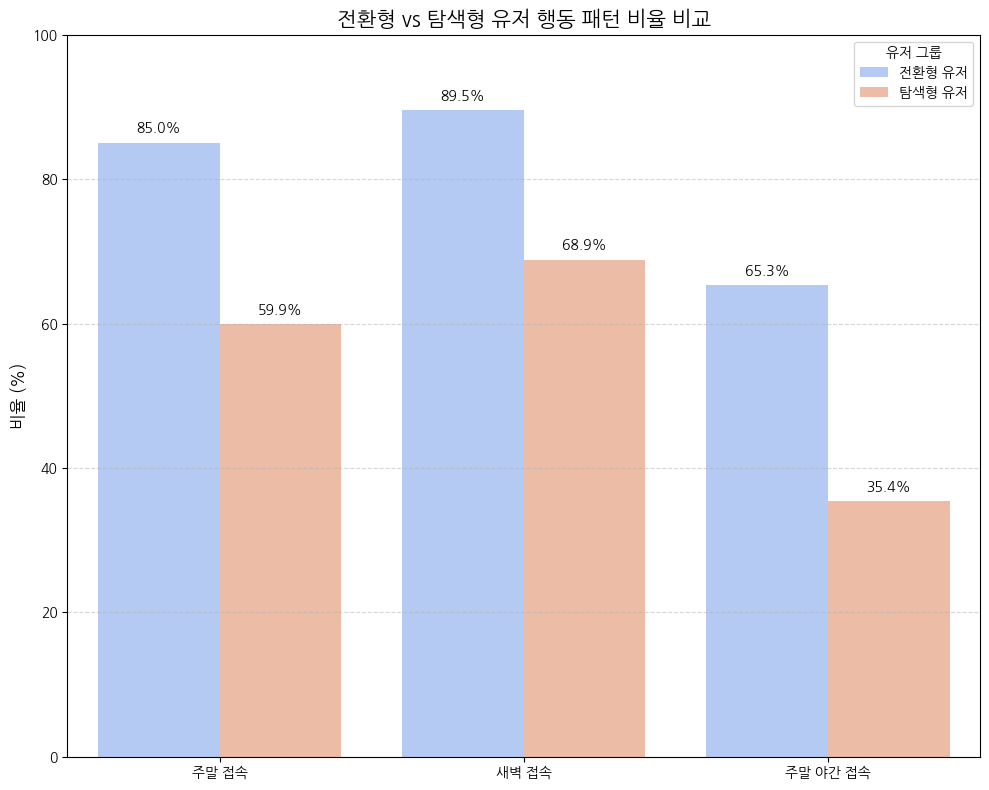

In [ ]:
# --- 1️⃣ 비율 계산 ---
apply_weekend = weekend_ratio_user_level(apply_group)
non_apply_weekend = weekend_ratio_user_level(non_apply_group)

apply_night = night_ratio_user_level(apply_group)
non_apply_night = night_ratio_user_level(non_apply_group)

apply_weekend_night = weekend_night_ratio_user_level(apply_group)
non_apply_weekend_night = weekend_night_ratio_user_level(non_apply_group)

# --- 2️⃣ 데이터프레임 구성 ---
ratio_df = pd.DataFrame({
    '행동유형': ['주말 접속', '새벽 접속', '주말 야간 접속'],
    '전환형 유저': [apply_weekend * 100, apply_night * 100, apply_weekend_night * 100],
    '탐색형 유저': [non_apply_weekend * 100, non_apply_night * 100, non_apply_weekend_night * 100]
})

# 긴 형태로 변환 (seaborn에서 그룹 비교용)
ratio_melted = ratio_df.melt(id_vars='행동유형', var_name='그룹', value_name='비율(%)')

# --- 3️⃣ 시각화 ---
plt.figure(figsize=(10, 8))
sns.barplot(data=ratio_melted, x='행동유형', y='비율(%)', hue='그룹', palette='coolwarm')

# --- 4️⃣ 그래프 꾸미기 ---
plt.title('전환형 vs 탐색형 유저 행동 패턴 비율 비교', fontsize=15)
plt.xlabel('')
plt.ylabel('비율 (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='유저 그룹')

# --- 5️⃣ 수치 라벨 표시 ---
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:  # 0 이상이면 표시하지 않음
        plt.text(
            p.get_x() + p.get_width()/2,
            height + 1,
            f"{height:.1f}%",
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.show()

##### 가설7. 탐색형유저는 전환형유저보다 알림으로 인한 접속이 더 많을 것이다.

###### Path의 행의 갯수 차이

In [ ]:
#'notification'이 포함된 행만 필터링
app_noti = apply_group[apply_group['path'].str.contains('notification', na=False)]
nonapp_noti = non_apply_group[non_apply_group['path'].str.contains('notification', na=False)]

# 행 개수
count_app_noti = len(app_noti)
count_nonapp_noti = len(nonapp_noti)
print("[전환형 그룹] Path에 notification 이 포함된 행의 수:", count_app_noti)
print("[탐색형 그룹] Path에 notification 이 포함된 행의 수", count_nonapp_noti)

[전환형 그룹] Path에 notification 이 포함된 행의 수: 190306
[탐색형 그룹] Path에 notification 이 포함된 행의 수 38916


###### Path의 유저 차이

In [ ]:
# 각 user_uuid별 notification 로그 수 계산
app_noti_per_user = app_noti.groupby('user_uuid')['path'].count()
nonapp_noti_per_user = nonapp_noti.groupby('user_uuid')['path'].count()

# 평균 계산
mean_app_noti = app_noti_per_user.mean()
mean_nonapp_noti = nonapp_noti_per_user.mean()

print(f"[전환형 그룹 유저] 1인당 평균 notification 로그 수: {mean_app_noti:.2f}")
print(f"[탐색형 그룹 유저] 1인당 평균 notification 로그 수: {mean_nonapp_noti:.2f}")


[전환형 그룹 유저] 1인당 평균 notification 로그 수: 17.24
[탐색형 그룹 유저] 1인당 평균 notification 로그 수: 9.94


##### 가설8. 22년 탐색형유저는 23년에 로그가 줄어들거나, 이탈(로그존재X)할 것이다.

###### 탐색형 그룹의 이탈율

In [ ]:
print("[탐색형 그룹의 이탈율]")
# 1) 2022년 탐색형 유저 목록
users_2022 = non_apply_group[non_apply_group['year'] == 2022]['user_uuid'].unique()

# 2) 2023년에도 등장한 유저 목록
users_2023 = non_apply_group[non_apply_group['year'] == 2023]['user_uuid'].unique()

retained = set(users_2022) & set(users_2023)  # 잔존
churned = set(users_2022) - set(users_2023)   # 이탈
print(f"총 2022 탐색형 유저 수: {len(users_2022)}")
print(f"2023년에 유지된 유저수: {len(retained)} ({len(retained)/len(users_2022):.2%})")
print(f"2023년에 완전히 이탈한 유저수: {len(churned)} ({len(churned)/len(users_2022):.2%})")

# 유저별 로그 수 비교
logs_2022 = non_apply_group[non_apply_group['year'] == 2022].groupby('user_uuid').size()
logs_2023 = non_apply_group[non_apply_group['year'] == 2023].groupby('user_uuid').size()

# 잔존 유저만 비교
retained_list = list(retained)
logs_2022_r = logs_2022.reindex(retained_list).fillna(0)
logs_2023_r = logs_2023.reindex(retained_list).fillna(0)

reduced = (logs_2023_r < logs_2022_r)  # 로그 감소된 유저
increased = (logs_2023_r > logs_2022_r)

print(f"잔존 유저 중 로그 감소 비율: {reduced.mean():.2%}")
print(f"잔존 유저 중 로그 증가 비율: {increased.mean():.2%}")

[탐색형 그룹의 이탈율]
총 2022 탐색형 유저 수: 4909
2023년에 유지된 유저수: 3112 (63.39%)
2023년에 완전히 이탈한 유저수: 1797 (36.61%)
잔존 유저 중 로그 감소 비율: 73.14%
잔존 유저 중 로그 증가 비율: 26.32%


###### 전환형 그룹의 이탈율

In [ ]:
print("[전환형 그룹의 이탈율]")
# 1) 2022년 탐색형 유저 목록
users_2022 = apply_group[apply_group['year'] == 2022]['user_uuid'].unique()

# 2) 2023년에도 등장한 유저 목록
users_2023 = apply_group[apply_group['year'] == 2023]['user_uuid'].unique()

retained = set(users_2022) & set(users_2023)  # 잔존
churned = set(users_2022) - set(users_2023)   # 이탈
print(f"총 2022 전환형 유저 수: {len(users_2022)}")
print(f"2023년에 유지된 유저수: {len(retained)} ({len(retained)/len(users_2022):.2%})")
print(f"2023년에 완전히 이탈한 유저수: {len(churned)} ({len(churned)/len(users_2022):.2%})")

# 유저별 로그 수 비교
logs_2022 = apply_group[apply_group['year'] == 2022].groupby('user_uuid').size()
logs_2023 = apply_group[apply_group['year'] == 2023].groupby('user_uuid').size()

# 잔존 유저만 비교
retained_list = list(retained)
logs_2022_r = logs_2022.reindex(retained_list).fillna(0)
logs_2023_r = logs_2023.reindex(retained_list).fillna(0)

reduced = (logs_2023_r < logs_2022_r)  # 로그 감소된 유저
increased = (logs_2023_r > logs_2022_r)

print(f"잔존 유저 중 로그 감소 비율: {reduced.mean():.2%}")
print(f"잔존 유저 중 로그 증가 비율: {increased.mean():.2%}")

[전환형 그룹의 이탈율]
총 2022 전환형 유저 수: 9600
2023년에 유지된 유저수: 7252 (75.54%)
2023년에 완전히 이탈한 유저수: 2348 (24.46%)
잔존 유저 중 로그 감소 비율: 65.64%
잔존 유저 중 로그 증가 비율: 34.34%


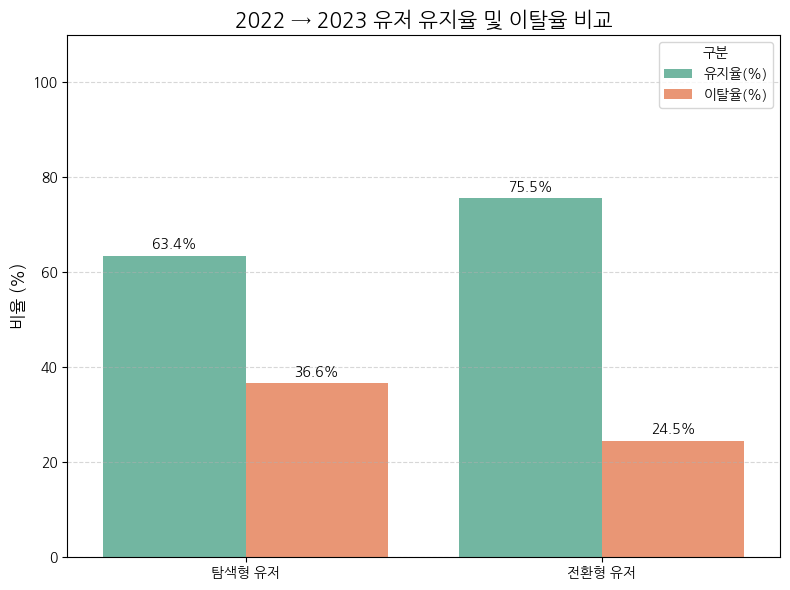

In [ ]:
# --- 1️⃣ 데이터 준비 (가정: 이미 계산된 집합) ---
# 탐색형
explorer_total = len(users_2022)
explorer_retained = len(retained)
explorer_churned = len(churned)

# 전환형 (별도로 계산한 users_2022_apply, retained_apply, churned_apply 가 있다면 아래를 수정)
apply_total = len(apply_users_2022)
apply_retained = apply_retained
apply_churned = apply_churned

# --- 2️⃣ 비율 계산 ---
ratio_df = pd.DataFrame({
    '그룹': ['탐색형 유저', '전환형 유저'],
    '유지율(%)': [
        explorer_retained / explorer_total * 100,
        apply_retained / apply_total * 100
    ],
    '이탈율(%)': [
        explorer_churned / explorer_total * 100,
        apply_churned / apply_total * 100
    ]
})

# --- 3️⃣ long format 변환 (시각화용) ---
ratio_melted = ratio_df.melt(id_vars='그룹', var_name='구분', value_name='비율(%)')

# --- 4️⃣ 시각화 ---
plt.figure(figsize=(8, 6))
sns.barplot(data=ratio_melted, x='그룹', y='비율(%)', hue='구분', palette='Set2')

# 제목 / 축 설정
plt.title('2022 → 2023 유저 유지율 및 이탈율 비교', fontsize=15)
plt.xlabel('')
plt.ylabel('비율 (%)', fontsize=12)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='구분')

# 수치 표시
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:  # 0보다 큰 막대만 라벨 표시
        plt.text(
            p.get_x() + p.get_width() / 2,
            height + 1,
            f"{height:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
plt.show()

##### 가설9. 22년 탐색형유저는 23년에 전환형유저가 될 것이다.

In [ ]:
import pandas as pd
from math import sqrt
from scipy.stats import norm


# 1️⃣ 22년 탐색형 유저 (지원 안 한 사람)
explorers_22 = (
    non_apply_group.loc[non_apply_group['year'] == 2022, 'user_uuid']
    .dropna().astype(str)
)
explorers_22 = set(explorers_22)

# 2️⃣ 23년 전환형 유저 (지원한 사람)
appliers_23 = (
    apply_group.loc[
        (apply_group['year'] == 2023) & (apply_group['apply존재여부'] == 1),
        'user_uuid'
    ]
    .dropna().astype(str)
)
appliers_23 = set(appliers_23)

# 3️⃣ 23년 전체 유저 (apply_group + non_apply_group)
users_23 = set()
for df in [apply_group, non_apply_group]:
    mask = df['year'] == 2023
    users_23.update(df.loc[mask, 'user_uuid'].dropna().astype(str))

# === 집합 관계 계산 ===
converted_users = explorers_22 & appliers_23                # 탐색형 → 전환형
non_explorers_23 = users_23 - explorers_22                  # 비탐색형 집합

# === 전환율 계산 ===
n_ex = len(explorers_22)
n_ap = len(appliers_23)
n_u23 = len(users_23)
n_conv = len(converted_users)

conv_rate_exp = (n_conv / n_ex * 100) if n_ex else 0.0

n_nonexp_conv = len(non_explorers_23 & appliers_23)
n_nonexp = len(non_explorers_23)
conv_rate_nonexp = (n_nonexp_conv / n_nonexp * 100) if n_nonexp else 0.0

# === 2표본 비율 검정 ===
def two_prop_ztest(success_a, size_a, success_b, size_b):
    if min(size_a, size_b) == 0:
        return float("nan"), 1.0
    p1 = success_a / size_a
    p2 = success_b / size_b
    p_pool = (success_a + success_b) / (size_a + size_b)
    se = sqrt(p_pool * (1 - p_pool) * (1/size_a + 1/size_b))
    if se == 0:
        return float("nan"), 1.0
    z = (p1 - p2) / se
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

z, p = two_prop_ztest(n_conv, n_ex, n_nonexp_conv, n_nonexp)

decision = (
    "유의하게 높음" if p < 0.05 and conv_rate_exp > conv_rate_nonexp else
    "유의하게 낮음" if p < 0.05 and conv_rate_exp < conv_rate_nonexp else
    "유의 차이 없음"
)

# === 결과 출력 ===
print(f"[2022 탐색형 그룹] 수: {n_ex:,}명")
print(f"[2023 전환형 그룹] 수: {n_ap:,}명")
print(f"2023 전체 유저 수: {n_u23:,}명")
print(f"탐색형→전환형 수: {n_conv:,}")
print(f"탐색형 전환율: {conv_rate_exp:.2f}%")
print(f"[비교] 비탐색형 전환율: {conv_rate_nonexp:.2f}%")
print(f"[z-test] z={z:.3f}, p={p:.6f} → {decision}")



[2022 탐색형 그룹] 수: 4,909명
[2023 전환형 그룹] 수: 10,125명
2023 전체 유저 수: 13,861명
탐색형→전환형 수: 0
탐색형 전환율: 0.00%
[비교] 비탐색형 전환율: 94.19%
[z-test] z=-114.393, p=0.000000 → 유의하게 낮음


##### 가설10. 전환형은 상세 페이지 체류 시간이 전환형보다 길 것이다.

In [ ]:
from scipy.stats import ttest_ind

# --- 상세페이지 탐색 로그만 추출 ---
def filter_detail_logs(df):
    mask = df["path"].astype(str).str.contains("detail|jobs/id|career/id", case=False, na=False)
    return df.loc[mask, ["user_uuid", "timestamp", "path"]].copy()

persona_detail = filter_detail_logs(apply_group)
control_detail = filter_detail_logs(non_apply_group)

# --- 타임스탬프 정렬 후 체류시간 계산 ---
def calc_dwell(df):
    df = df.sort_values(["user_uuid", "timestamp"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["next_time"] = df.groupby("user_uuid")["timestamp"].shift(-1)
    df["stay_sec"] = (df["next_time"] - df["timestamp"]).dt.total_seconds()
    df = df[df["stay_sec"].between(1, 3600)]  # 1초~1시간 사이 체류만 유효하게
    return df

persona_dwell = calc_dwell(persona_detail)
control_dwell = calc_dwell(control_detail)

# --- 사용자별 평균 체류시간 계산 ---
persona_user_mean = persona_dwell.groupby("user_uuid")["stay_sec"].mean()
control_user_mean = control_dwell.groupby("user_uuid")["stay_sec"].mean()

# --- 통계 비교 ---
t_stat, p_val = ttest_ind(control_user_mean, persona_user_mean, equal_var=False, nan_policy='omit')


print(f"[탐색형 그룹] 평균 체류시간: {persona_user_mean.mean():.2f}초")
print(f"[전환형 그룹] 평균 체류시간: {control_user_mean.mean():.2f}초")
print(f"t통계량 = {t_stat:.3f}, p값 = {p_val:.6f}")
print("결론:",
      " 전환형이 유의하게 더 길다 (가설 채택)" if p_val < 0.05 and control_user_mean.mean() > persona_user_mean.mean()
      else "유의한 차이 없음 (가설 기각)")

[탐색형 그룹] 평균 체류시간: 134.07초
[전환형 그룹] 평균 체류시간: 127.08초
t통계량 = -2.059, p값 = 0.039574
결론: 유의한 차이 없음 (가설 기각)


##### 가설11. 탐색형의 경우 신규가입자 비율이 전환형보다 높게 나타날 것이다

In [ ]:
# apply_group에서 api/signup/form 방문 유저 수
apply_signup_users = apply_group[apply_group['path'] == 'api/signup/form']['user_uuid'].nunique()
apply_total_users = apply_group['user_uuid'].nunique()
apply_signup_rate = apply_signup_users / apply_total_users * 100

# non_apply_group에서 api/signup/form 방문 유저 수
non_apply_signup_users = non_apply_group[non_apply_group['path'] == 'api/signup/form']['user_uuid'].nunique()
non_apply_total_users = non_apply_group['user_uuid'].nunique()
non_apply_signup_rate = non_apply_signup_users / non_apply_total_users * 100

print(f"[전환형 그룹] 신규가입 비율: {apply_signup_rate:.2f}% ({apply_signup_users}/{apply_total_users})")
print(f"[탐색형 그룹] 신규가입 비율: {non_apply_signup_rate:.2f}% ({non_apply_signup_users}/{non_apply_total_users})")


[전환형 그룹] 신규가입 비율: 18.33% (2286/12473)
[탐색형 그룹] 신규가입 비율: 0.58% (32/5533)


#### 전체 유저 로그 EDA

##### 탐색형 집단 EDA

##### 탐색형 집단 matrix 분리 및 집단별 특성 분석

###### 매트릭스 그려보기

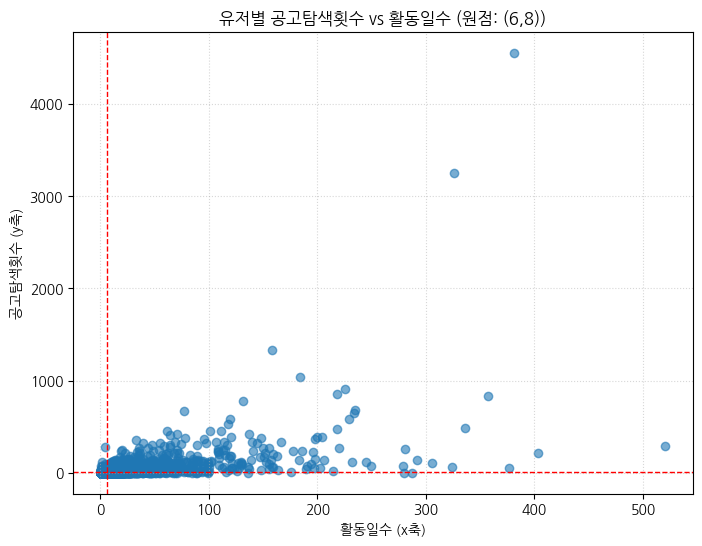

In [ ]:
# 두 데이터 병합
user_summary = job_search_counts.merge(user_active_days, on='user_uuid', how='outer').fillna(0)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(user_summary['active_days'], user_summary['job_search_count'], alpha=0.6)

# 원점 (7,7) 표시
plt.axvline(x=6, color='red', linestyle='--', linewidth=1)
plt.axhline(y=8, color='red', linestyle='--', linewidth=1)

# 축 라벨 및 제목
plt.xlabel('활동일수 (x축)')
plt.ylabel('공고탐색횟수 (y축)')
plt.title('유저별 공고탐색횟수 vs 활동일수 (원점: (6,8))')

plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

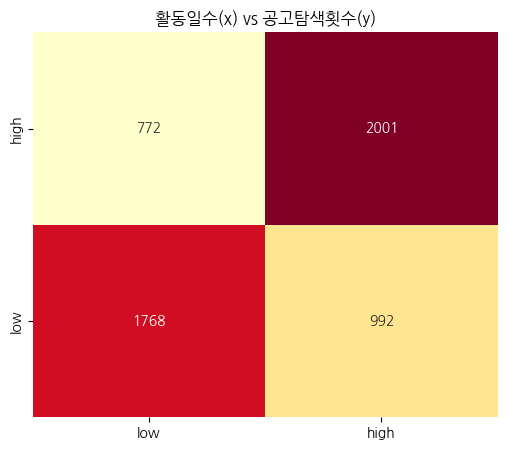

In [ ]:
# 사분면 구분
def assign_quadrant(row):
    if row['active_days'] >= 6 and row['job_search_count'] >= 8:
        return '1사분면'
    elif row['active_days'] < 6 and row['job_search_count'] >= 8:
        return '2사분면'
    elif row['active_days'] < 6 and row['job_search_count'] < 8:
        return '3사분면'
    else:
        return '4사분면'

user_summary['quadrant'] = user_summary.apply(assign_quadrant, axis=1)

# 각 사분면별 유저 수 집계
quadrant_counts = user_summary['quadrant'].value_counts().reindex(['2사분면', '1사분면', '3사분면', '4사분면'])
heatmap_data = pd.DataFrame([[quadrant_counts['2사분면'], quadrant_counts['1사분면']],
                             [quadrant_counts['3사분면'], quadrant_counts['4사분면']]],
                            index=['high', 'low'],
                            columns=['low', 'high'])

# 히트맵 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar=False)
plt.title('활동일수(x) vs 공고탐색횟수(y)')
plt.show()

###### 사분면 컬럼 생성
- 유저당 공고탐색수가 7이상, 유저당 활동일수 8이상은 "사분면"컬럼에 "1"
- 유저당 공고탐색수가 7이상, 유저당 활동일수 8미만은 "사분면"컬럼에 "2"
- 유저당 공고탐색수가 7미만, 유저당 활동일수 8미만은 "사분면"컬럼에 "3"
- 유저당 공고탐색수가 7미만, 유저당 활동일수 8이상은 "사분면"컬럼에 "4"

In [ ]:
# persona_df에 '사분면' 컬럼 추가 (user_uuid 기준 매칭)
persona_df = persona_df.merge(
    user_summary[['user_uuid', 'quadrant']],
    on='user_uuid',
    how='left'
)

# 컬럼명 통일
persona_df = persona_df.rename(columns={'quadrant': '사분면'})

In [ ]:
persona_df.head()

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,path,query_string,year,timestamp_utc,timestamp_kst,apply존재여부,사분면
0,243,207a8876-2a6c-4137-9347-476ce719c541,api/users/id/template,2022-06-22 22:09:35.636502 UTC,2022-06-23,200,POST,api/users/id/template,NaN,2022,2022-06-22 22:09:35.636502+00:00,2022-06-23 07:09:35.636502+09:00,0,1사분면
1,244,207a8876-2a6c-4137-9347-476ce719c541,search?keywords=생물정보학,2022-11-17 20:39:42.038713 UTC,2022-11-18,200,GET,search,keywords=생물정보학,2022,2022-11-17 20:39:42.038713+00:00,2022-11-18 05:39:42.038713+09:00,0,1사분면
2,245,207a8876-2a6c-4137-9347-476ce719c541,suggest?q=생물,2022-11-17 20:39:39.718239 UTC,2022-11-18,200,GET,suggest,q=생물,2022,2022-11-17 20:39:39.718239+00:00,2022-11-18 05:39:39.718239+09:00,0,1사분면
3,246,207a8876-2a6c-4137-9347-476ce719c541,suggest?q=생,2022-11-17 20:39:38.41961 UTC,2022-11-18,200,GET,suggest,q=생,2022,2022-11-17 20:39:38.419610+00:00,2022-11-18 05:39:38.419610+09:00,0,1사분면
4,247,207a8876-2a6c-4137-9347-476ce719c541,search?keywords=마이크로바이옴,2022-04-13 22:16:25.601246 UTC,2022-04-14,200,GET,search,keywords=마이크로바이옴,2022,2022-04-13 22:16:25.601246+00:00,2022-04-14 07:16:25.601246+09:00,0,1사분면


In [ ]:
persona_df.loc[persona_df['사분면'] == '1사분면', 'user_uuid'].nunique()

2001

In [ ]:
persona_df.loc[persona_df['사분면'] == '2사분면', 'user_uuid'].nunique()

772

In [ ]:
persona_df.loc[persona_df['사분면'] == '3사분면', 'user_uuid'].nunique()

1768

In [ ]:
persona_df.loc[persona_df['사분면'] == '4사분면', 'user_uuid'].nunique()

992

In [ ]:
persona_df.to_csv('/content/drive/MyDrive/중급프로젝트(6팀)/기본 제공 데이터/수정작업/찐찐최종 로그/탐색형_로그(사분면분리).csv', index=False, encoding='utf-8-sig')

###### 사분면 집단별 특성 - 분포파악/사분면 그려보기

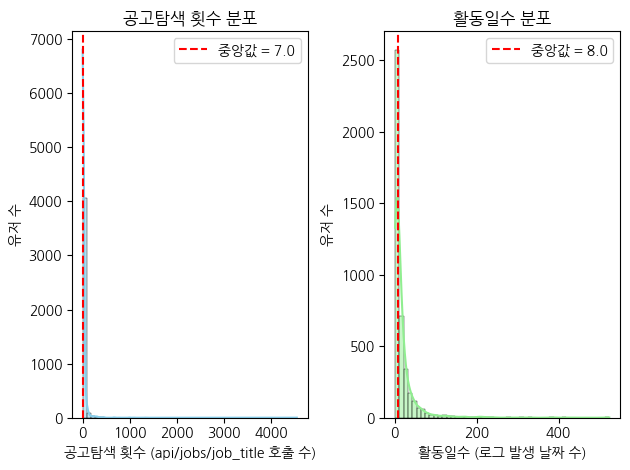

In [ ]:
# (1) 공고탐색 횟수 분포
# -----------------------------
plt.subplot(1,2,1)
sns.histplot(u['job_title_search_cnt'], bins=50, color='skyblue', kde=True)
plt.axvline(u['job_title_search_cnt'].median(), color='red', linestyle='--', label=f"중앙값 = {u['job_title_search_cnt'].median():.1f}")
plt.title('공고탐색 횟수 분포')
plt.xlabel('공고탐색 횟수 (api/jobs/job_title 호출 수)')
plt.ylabel('유저 수')
plt.legend()

# -----------------------------
# (2) 활동일수 분포
# -----------------------------
plt.subplot(1,2,2)
sns.histplot(u['active_days'], bins=50, color='lightgreen', kde=True)
plt.axvline(u['active_days'].median(), color='red', linestyle='--', label=f"중앙값 = {u['active_days'].median():.1f}")
plt.title('활동일수 분포')
plt.xlabel('활동일수 (로그 발생 날짜 수)')
plt.ylabel('유저 수')
plt.legend()

plt.tight_layout()
plt.show()

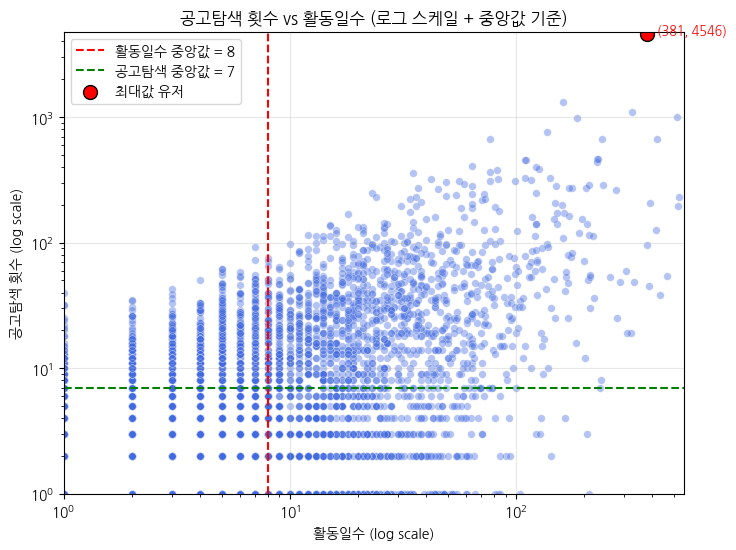

In [ ]:

# 중앙값 계산
median_job = u['job_title_search_cnt'].median()
median_days = u['active_days'].median()

# 최대값 위치 찾기
max_row = u.loc[u['job_title_search_cnt'].idxmax()]  # 공고탐색 횟수 최댓값 유저

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=u, x='active_days', y='job_title_search_cnt',
    alpha=0.4, s=30, color='royalblue'
)

# 중앙값 기준선
plt.axvline(median_days, color='red', linestyle='--', label=f'활동일수 중앙값 = {median_days:.0f}')
plt.axhline(median_job, color='green', linestyle='--', label=f'공고탐색 중앙값 = {median_job:.0f}')

# 로그 스케일 적용 (극단치 포함)
plt.xscale('log')
plt.yscale('log')

# 축 범위: 최소값 1, 최대값 5% 여유 있게
plt.xlim(1, u['active_days'].max() * 1.05)
plt.ylim(1, u['job_title_search_cnt'].max() * 1.05)

# 최대값 유저 표시 (빨간 점 + 텍스트)
plt.scatter(max_row['active_days'], max_row['job_title_search_cnt'],
            color='red', s=100, label='최대값 유저', edgecolor='black')
plt.text(max_row['active_days'] * 1.1, max_row['job_title_search_cnt'],
         f"({int(max_row['active_days'])}, {int(max_row['job_title_search_cnt'])})",
         color='red', fontsize=9)

# 제목 / 축 라벨
plt.title('공고탐색 횟수 vs 활동일수 (로그 스케일 + 중앙값 기준)')
plt.xlabel('활동일수 (log scale)')
plt.ylabel('공고탐색 횟수 (log scale)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

###### 사분면 집단별 특성 파악 (1사분면)

In [ ]:
first_q = matrix_df[matrix_df['사분면'] == '1사분면']
basic_eda(first_q)


❌ 칼럼 'timestamp' 변환 실패: time data "2022-01-18 03:04:07" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 65114. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


/tmp/ipython-input-4030955573.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-4030955573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')


✅ 칼럼 'date_kst'을(를) datetime(UTC 포함)으로 변환했습니다.

[1] 데이터 크기 (행, 열):
(1145917, 15) 

[2] 칼럼 이름과 데이터 타입:
- Unnamed: 0: int64
- user_uuid: object
- URL: object
- timestamp: object
- date: datetime64[ns]
- response_code: int64
- method: object
- path: object
- query_string: object
- year: int64
- timestamp_utc: datetime64[ns, UTC]
- timestamp_kst: datetime64[ns, UTC+09:00]
- apply존재여부: int64
- 사분면: object
- date_kst: datetime64[ns]

[3] 각 칼럼 결측치 수와 중복값 수:
- Unnamed: 0: 결측치 0개, 중복값 21738개, 고유값 1124179개
- user_uuid: 결측치 0개, 중복값 1143916개, 고유값 2001개
- URL: 결측치 0개, 중복값 938786개, 고유값 207131개
- timestamp: 결측치 0개, 중복값 128개, 고유값 1145789개
- date: 결측치 0개, 중복값 1145187개, 고유값 730개
- response_code: 결측치 0개, 중복값 1145906개, 고유값 11개
- method: 결측치 0개, 중복값 1145913개, 고유값 4개
- path: 결측치 0개, 중복값 1145691개, 고유값 226개
- query_string: 결측치 702410개, 중복값 947357개, 고유값 198559개
- year: 결측치 0개, 중복값 1145915개, 고유값 2개
- timestamp_utc: 결측치 3개, 중복값 130개, 고유값 1145786개
- timestamp_kst: 결측치 3개, 중복값 130개, 고유값 1145786개
- apply존재여부: 결측치 0

In [ ]:
first_q.head()

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,path,query_string,year,timestamp_utc,timestamp_kst,apply존재여부,사분면,date_kst
0,243,207a8876-2a6c-4137-9347-476ce719c541,api/users/id/template,2022-06-22 22:09:35.636502 UTC,2022-06-23,200,POST,api/users/id/template,NaN,2022,2022-06-22 22:09:35.636502+00:00,2022-06-23 07:09:35.636502+09:00,0,1사분면,2022-06-23
1,244,207a8876-2a6c-4137-9347-476ce719c541,search?keywords=생물정보학,2022-11-17 20:39:42.038713 UTC,2022-11-18,200,GET,search,keywords=생물정보학,2022,2022-11-17 20:39:42.038713+00:00,2022-11-18 05:39:42.038713+09:00,0,1사분면,2022-11-18
2,245,207a8876-2a6c-4137-9347-476ce719c541,suggest?q=생물,2022-11-17 20:39:39.718239 UTC,2022-11-18,200,GET,suggest,q=생물,2022,2022-11-17 20:39:39.718239+00:00,2022-11-18 05:39:39.718239+09:00,0,1사분면,2022-11-18
3,246,207a8876-2a6c-4137-9347-476ce719c541,suggest?q=생,2022-11-17 20:39:38.41961 UTC,2022-11-18,200,GET,suggest,q=생,2022,2022-11-17 20:39:38.419610+00:00,2022-11-18 05:39:38.419610+09:00,0,1사분면,2022-11-18
4,247,207a8876-2a6c-4137-9347-476ce719c541,search?keywords=마이크로바이옴,2022-04-13 22:16:25.601246 UTC,2022-04-14,200,GET,search,keywords=마이크로바이옴,2022,2022-04-13 22:16:25.601246+00:00,2022-04-14 07:16:25.601246+09:00,0,1사분면,2022-04-14


In [ ]:
########### 방문일수 (중앙값 18)

In [ ]:
# 방문일수
first_q_active_days = first_q.groupby('user_uuid')['date_kst'].nunique()
first_q_active_days.describe()

,date_kst
count,2001.000000
mean,31.240380
std,42.011161
min,6.000000
25%,10.000000
50%,18.000000
75%,34.000000
max,520.000000


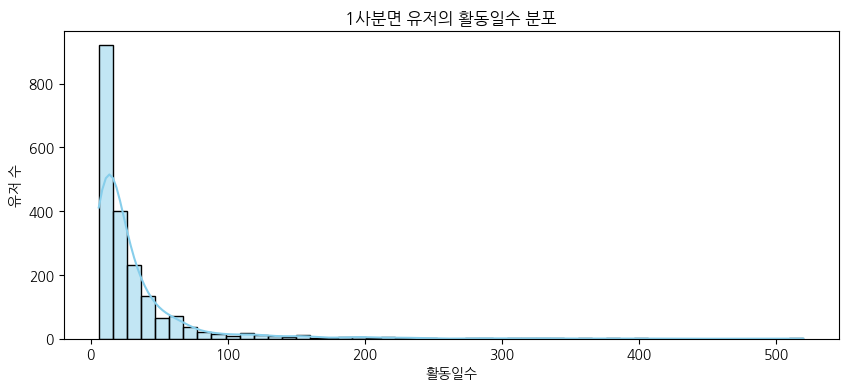

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(first_q_active_days, bins=50, kde=True, color='skyblue')
plt.title("1사분면 유저의 활동일수 분포")
plt.xlabel("활동일수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
########## 공고탐색 (중앙값 27)

In [ ]:
# 탐색수
first_q_job_title_counts = first_q.groupby('user_uuid')['path'].apply(lambda x: (x.str.contains('api/jobs/job_title|api/recommend_specialty', na=False)).sum())
first_q_job_title_counts.describe()

,path
count,2001.000000
mean,54.280860
std,149.053873
min,8.000000
25%,14.000000
50%,27.000000
75%,52.000000
max,4551.000000


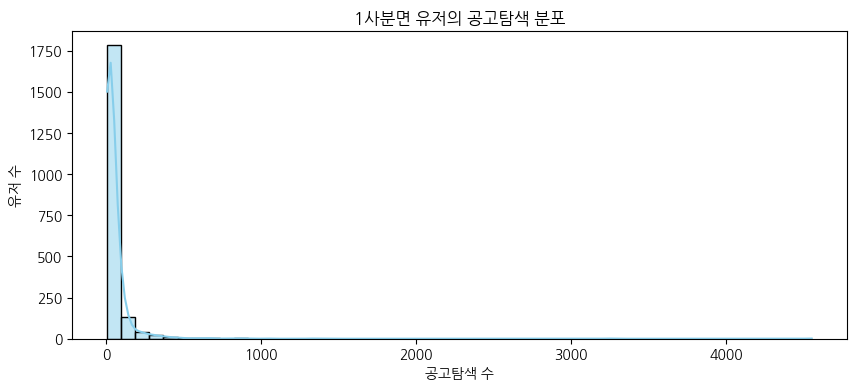

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(first_q_job_title_counts, bins=50, kde=True, color='skyblue')
plt.title("1사분면 유저의 공고탐색 분포")
plt.xlabel("공고탐색 수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
############## 체류시간 (중앙값 42.424070분)

In [ ]:
# 1. timestamp_kst가 datetime 형태인지 확인 및 변환
first_q['timestamp_kst'] = pd.to_datetime(first_q['timestamp_kst'], errors='coerce')

# 2. 날짜 컬럼 생성
first_q['date'] = first_q['timestamp_kst'].dt.date

# 3. 유저 × 날짜별 하루 체류시간 계산
daily_stay1 = (
    first_q.groupby(['user_uuid', 'date'])['timestamp_kst']
    .agg(['min', 'max'])  # 하루 중 첫 로그, 마지막 로그
    .reset_index()
)

# 4. 체류시간(초 단위) 계산
daily_stay1['stay_duration'] = (daily_stay1['max'] - daily_stay1['min']).dt.total_seconds()

# 5. 유저별 하루 평균 체류시간 계산 (초 단위)
user_avg_stay1 = (
    daily_stay1.groupby('user_uuid')['stay_duration']
    .mean()
    .reset_index()
    .rename(columns={'stay_duration': 'avg_daily_stay_sec'})
)

# 6. 시간 단위로 보기 좋게 변환 (예: 분 단위 추가)
user_avg_stay1['avg_daily_stay_min'] = user_avg_stay1['avg_daily_stay_sec'] / 60
user_avg_stay1['avg_daily_stay_hour'] = user_avg_stay1['avg_daily_stay_sec'] / 3600

# 7. 결과 확인
user_avg_stay1.describe()



/tmp/ipython-input-3199338898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_q['timestamp_kst'] = pd.to_datetime(first_q['timestamp_kst'], errors='coerce')
/tmp/ipython-input-3199338898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_q['date'] = first_q['timestamp_kst'].dt.date


,avg_daily_stay_sec,avg_daily_stay_min,avg_daily_stay_hour
count,2001.000000,2001.000000,2001.000000
mean,3655.927578,60.932126,1.015535
std,4021.087508,67.018125,1.116969
min,14.167407,0.236123,0.003935
25%,817.959056,13.632651,0.227211
50%,2545.444200,42.424070,0.707068
75%,5015.319990,83.588667,1.393144
max,45802.227094,763.370452,12.722841


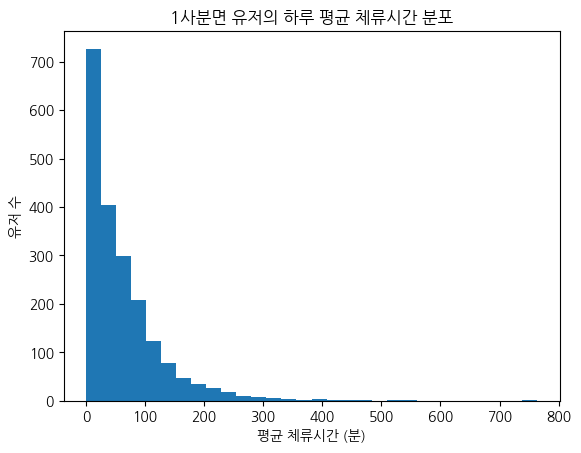

In [ ]:
plt.hist(user_avg_stay1['avg_daily_stay_min'], bins=30)
plt.xlabel('평균 체류시간 (분)')
plt.ylabel('유저 수')
plt.title('1사분면 유저의 하루 평균 체류시간 분포')
plt.show()

In [ ]:
first_q = matrix_df[matrix_df['사분면'] == '1사분면']
basic_eda(first_q)

❌ 칼럼 'timestamp' 변환 실패: time data "2022-01-18 03:04:07" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 65114. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


/tmp/ipython-input-4030955573.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-4030955573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')


✅ 칼럼 'date_kst'을(를) datetime(UTC 포함)으로 변환했습니다.

[1] 데이터 크기 (행, 열):
(1145917, 15) 

[2] 칼럼 이름과 데이터 타입:
- Unnamed: 0: int64
- user_uuid: object
- URL: object
- timestamp: object
- date: datetime64[ns]
- response_code: int64
- method: object
- path: object
- query_string: object
- year: int64
- timestamp_utc: datetime64[ns, UTC]
- timestamp_kst: datetime64[ns, UTC+09:00]
- apply존재여부: int64
- 사분면: object
- date_kst: datetime64[ns]

[3] 각 칼럼 결측치 수와 중복값 수:
- Unnamed: 0: 결측치 0개, 중복값 21738개, 고유값 1124179개
- user_uuid: 결측치 0개, 중복값 1143916개, 고유값 2001개
- URL: 결측치 0개, 중복값 938786개, 고유값 207131개
- timestamp: 결측치 0개, 중복값 128개, 고유값 1145789개
- date: 결측치 0개, 중복값 1145187개, 고유값 730개
- response_code: 결측치 0개, 중복값 1145906개, 고유값 11개
- method: 결측치 0개, 중복값 1145913개, 고유값 4개
- path: 결측치 0개, 중복값 1145691개, 고유값 226개
- query_string: 결측치 702410개, 중복값 947357개, 고유값 198559개
- year: 결측치 0개, 중복값 1145915개, 고유값 2개
- timestamp_utc: 결측치 3개, 중복값 130개, 고유값 1145786개
- timestamp_kst: 결측치 3개, 중복값 130개, 고유값 1145786개
- apply존재여부: 결측치 0

###### 사분면 집단별 특성 파악 (2사분면)

In [ ]:
second_q = matrix_df[matrix_df['사분면'] == '2사분면']
basic_eda(second_q)


/tmp/ipython-input-4030955573.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col].astype(str).str.replace(' UTC', '', regex=False), utc=True)
/tmp/ipython-input-4030955573.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-4030955573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

✅ 칼럼 'timestamp'을(를) datetime(UTC 포함)으로 변환했습니다.
✅ 칼럼 'date_kst'을(를) datetime(UTC 포함)으로 변환했습니다.

[1] 데이터 크기 (행, 열):
(75981, 15) 

[2] 칼럼 이름과 데이터 타입:
- Unnamed: 0: int64
- user_uuid: object
- URL: object
- timestamp: datetime64[ns, UTC]
- date: datetime64[ns]
- response_code: int64
- method: object
- path: object
- query_string: object
- year: int64
- timestamp_utc: datetime64[ns, UTC]
- timestamp_kst: datetime64[ns, UTC+09:00]
- apply존재여부: int64
- 사분면: object
- date_kst: datetime64[ns]

[3] 각 칼럼 결측치 수와 중복값 수:
- Unnamed: 0: 결측치 0개, 중복값 259개, 고유값 75722개
- user_uuid: 결측치 0개, 중복값 75209개, 고유값 772개
- URL: 결측치 0개, 중복값 55684개, 고유값 20297개
- timestamp: 결측치 0개, 중복값 0개, 고유값 75981개
- date: 결측치 0개, 중복값 75328개, 고유값 653개
- response_code: 결측치 0개, 중복값 75972개, 고유값 9개
- method: 결측치 0개, 중복값 75977개, 고유값 4개
- path: 결측치 0개, 중복값 75790개, 고유값 191개
- query_string: 결측치 41929개, 중복값 56623개, 고유값 19357개
- year: 결측치 0개, 중복값 75979개, 고유값 2개
- timestamp_utc: 결측치 0개, 중복값 0개, 고유값 75981개
- timestamp_kst: 결측치 0개, 중복값 0개, 고유값 7

In [ ]:
############ 방문일수 (중앙값 3)

In [ ]:
# 방문일수
second_q_active_days = second_q.groupby('user_uuid')['date_kst'].nunique()
second_q_active_days.describe()

,date_kst
count,772.000000
mean,3.113990
std,1.378908
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


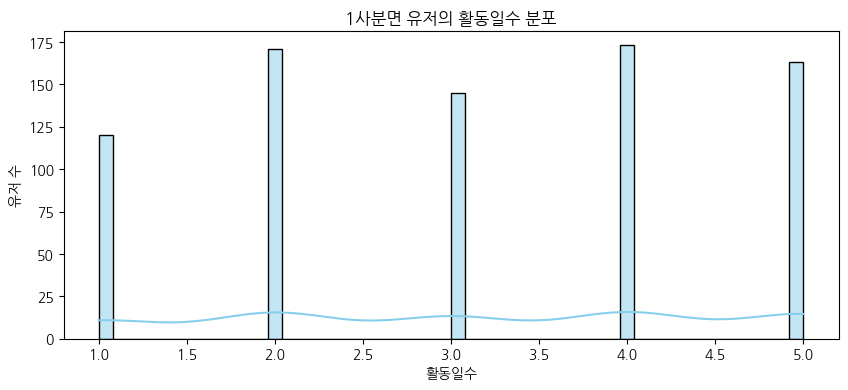

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(second_q_active_days, bins=50, kde=True, color='skyblue')
plt.title("1사분면 유저의 활동일수 분포")
plt.xlabel("활동일수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
########### 공고탐색 (중앙값 13.5)

In [ ]:
# 탐색수
second_q_job_title_counts = second_q.groupby('user_uuid')['path'].apply(lambda x: (x.str.contains('api/jobs/job_title|api/recommend_specialty', na=False)).sum())
second_q_job_title_counts.describe()

,path
count,772.000000
mean,17.294041
std,14.551677
min,8.000000
25%,10.000000
50%,13.500000
75%,20.000000
max,283.000000


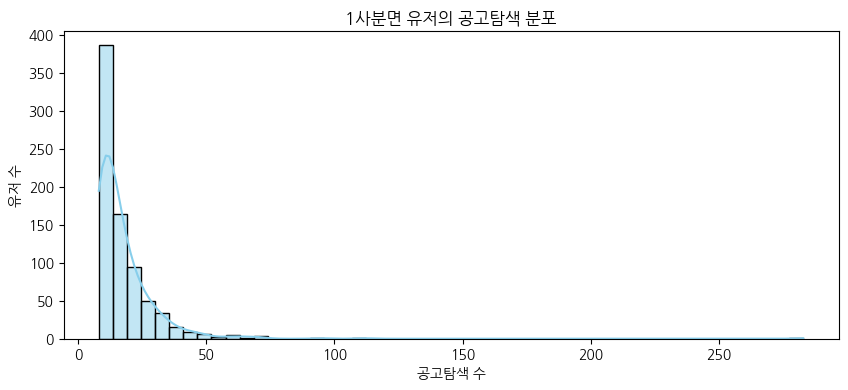

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(second_q_job_title_counts, bins=50, kde=True, color='skyblue')
plt.title("1사분면 유저의 공고탐색 분포")
plt.xlabel("공고탐색 수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
############ 체류시간 (중앙값 10.650824)

In [ ]:
# 1. timestamp_kst가 datetime 형태인지 확인 및 변환
second_q['timestamp_kst'] = pd.to_datetime(second_q['timestamp_kst'], errors='coerce')

# 2. 날짜 컬럼 생성
second_q['date'] = second_q['timestamp_kst'].dt.date

# 3. 유저 × 날짜별 하루 체류시간 계산
daily_stay2 = (
    second_q.groupby(['user_uuid', 'date'])['timestamp_kst']
    .agg(['min', 'max'])  # 하루 중 첫 로그, 마지막 로그
    .reset_index()
)

# 4. 체류시간(초 단위) 계산
daily_stay2['stay_duration'] = (daily_stay2['max'] - daily_stay2['min']).dt.total_seconds()

# 5. 유저별 하루 평균 체류시간 계산 (초 단위)
user_avg_stay2 = (
    daily_stay2.groupby('user_uuid')['stay_duration']
    .mean()
    .reset_index()
    .rename(columns={'stay_duration': 'avg_daily_stay_sec'})
)

# 6. 시간 단위로 보기 좋게 변환 (예: 분 단위 추가)
user_avg_stay2['avg_daily_stay_min'] = user_avg_stay2['avg_daily_stay_sec'] / 60
user_avg_stay2['avg_daily_stay_hour'] = user_avg_stay2['avg_daily_stay_sec'] / 3600

# 7. 결과 확인
user_avg_stay2.describe()



/tmp/ipython-input-2654310035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_q['timestamp_kst'] = pd.to_datetime(second_q['timestamp_kst'], errors='coerce')
/tmp/ipython-input-2654310035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_q['date'] = second_q['timestamp_kst'].dt.date


,avg_daily_stay_sec,avg_daily_stay_min,avg_daily_stay_hour
count,772.000000,772.000000,772.000000
mean,2467.533549,41.125559,0.685426
std,4733.032804,78.883880,1.314731
min,24.561602,0.409360,0.006823
25%,244.576708,4.076278,0.067938
50%,639.049420,10.650824,0.177514
75%,2198.653340,36.644222,0.610737
max,46793.675827,779.894597,12.998243


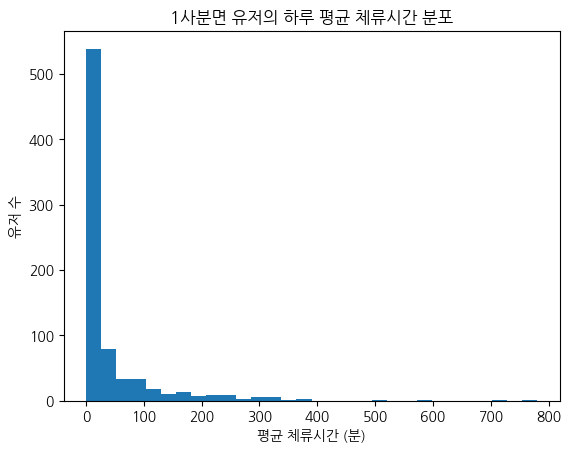

In [ ]:
plt.hist(user_avg_stay2['avg_daily_stay_min'], bins=30)
plt.xlabel('평균 체류시간 (분)')
plt.ylabel('유저 수')
plt.title('1사분면 유저의 하루 평균 체류시간 분포')
plt.show()

###### 사분면 집단별 특성 파악 (3사분면)

In [ ]:
third_q = matrix_df[matrix_df['사분면'] == '3사분면']

In [ ]:
basic_eda(third_q)

/tmp/ipython-input-4030955573.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col].astype(str).str.replace(' UTC', '', regex=False), utc=True)
/tmp/ipython-input-4030955573.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-4030955573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

✅ 칼럼 'timestamp'을(를) datetime(UTC 포함)으로 변환했습니다.
✅ 칼럼 'date_kst'을(를) datetime(UTC 포함)으로 변환했습니다.

[1] 데이터 크기 (행, 열):
(77557, 15) 

[2] 칼럼 이름과 데이터 타입:
- Unnamed: 0: int64
- user_uuid: object
- URL: object
- timestamp: datetime64[ns, UTC]
- date: datetime64[ns]
- response_code: int64
- method: object
- path: object
- query_string: object
- year: int64
- timestamp_utc: datetime64[ns, UTC]
- timestamp_kst: datetime64[ns, UTC+09:00]
- apply존재여부: int64
- 사분면: object
- date_kst: datetime64[ns]

[3] 각 칼럼 결측치 수와 중복값 수:
- Unnamed: 0: 결측치 0개, 중복값 41개, 고유값 77516개
- user_uuid: 결측치 0개, 중복값 75789개, 고유값 1768개
- URL: 결측치 0개, 중복값 58946개, 고유값 18611개
- timestamp: 결측치 0개, 중복값 0개, 고유값 77557개
- date: 결측치 0개, 중복값 76851개, 고유값 706개
- response_code: 결측치 0개, 중복값 77548개, 고유값 9개
- method: 결측치 0개, 중복값 77553개, 고유값 4개
- path: 결측치 0개, 중복값 77362개, 고유값 195개
- query_string: 결측치 47360개, 중복값 59918개, 고유값 17638개
- year: 결측치 0개, 중복값 77555개, 고유값 2개
- timestamp_utc: 결측치 0개, 중복값 0개, 고유값 77557개
- timestamp_kst: 결측치 0개, 중복값 0개, 고유값 7

In [ ]:
########### 방문일수 (중앙값 2)

In [ ]:
# 방문일수
third_q_active_days = third_q.groupby('user_uuid')['date_kst'].nunique()
third_q_active_days.describe()

,date_kst
count,1768.000000
mean,2.409502
std,1.356933
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,5.000000


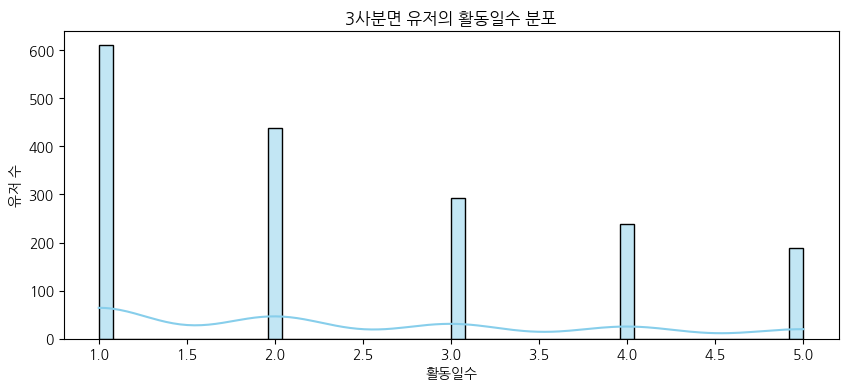

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(third_q_active_days, bins=50, kde=True, color='skyblue')
plt.title("3사분면 유저의 활동일수 분포")
plt.xlabel("활동일수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
############ 공고탐색 (중앙값 2)

In [ ]:
# 탐색수
third_q_job_title_counts = third_q.groupby('user_uuid')['path'].apply(lambda x: (x.str.contains('api/jobs/job_title|api/recommend_specialty', na=False)).sum())
third_q_job_title_counts.describe()

,path
count,1768.000000
mean,2.871041
std,1.908578
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,7.000000


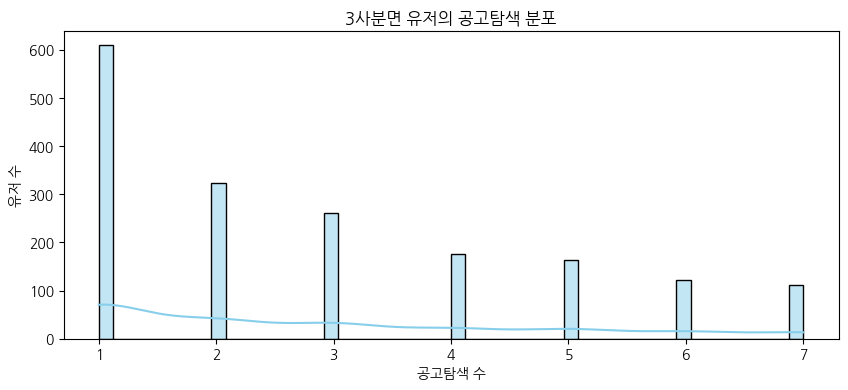

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(third_q_job_title_counts, bins=50, kde=True, color='skyblue')
plt.title("3사분면 유저의 공고탐색 분포")
plt.xlabel("공고탐색 수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
########### 체류시간 (중앙값 3.371659분)

In [ ]:
# 1. timestamp_kst가 datetime 형태인지 확인 및 변환
third_q['timestamp_kst'] = pd.to_datetime(third_q['timestamp_kst'], errors='coerce')

# 2. 날짜 컬럼 생성
third_q['date'] = third_q['timestamp_kst'].dt.date

# 3. 유저 × 날짜별 하루 체류시간 계산
daily_stay3 = (
    third_q.groupby(['user_uuid', 'date'])['timestamp_kst']
    .agg(['min', 'max'])  # 하루 중 첫 로그, 마지막 로그
    .reset_index()
)

# 4. 체류시간(초 단위) 계산
daily_stay3['stay_duration'] = (daily_stay3['max'] - daily_stay3['min']).dt.total_seconds()

# 5. 유저별 하루 평균 체류시간 계산 (초 단위)
user_avg_stay3 = (
    daily_stay3.groupby('user_uuid')['stay_duration']
    .mean()
    .reset_index()
    .rename(columns={'stay_duration': 'avg_daily_stay_sec'})
)

# 6. 시간 단위로 보기 좋게 변환 (예: 분 단위 추가)
user_avg_stay3['avg_daily_stay_min'] = user_avg_stay3['avg_daily_stay_sec'] / 60
user_avg_stay3['avg_daily_stay_hour'] = user_avg_stay3['avg_daily_stay_sec'] / 3600

# 7. 결과 확인
user_avg_stay3.describe()



/tmp/ipython-input-2021513703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_q['timestamp_kst'] = pd.to_datetime(third_q['timestamp_kst'], errors='coerce')
/tmp/ipython-input-2021513703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_q['date'] = third_q['timestamp_kst'].dt.date


,avg_daily_stay_sec,avg_daily_stay_min,avg_daily_stay_hour
count,1768.000000,1768.000000,1768.000000
mean,1625.900510,27.098342,0.451639
std,5231.881861,87.198031,1.453301
min,0.263763,0.004396,0.000073
25%,77.853346,1.297556,0.021626
50%,202.299522,3.371659,0.056194
75%,707.738060,11.795634,0.196594
max,79011.891216,1316.864854,21.947748


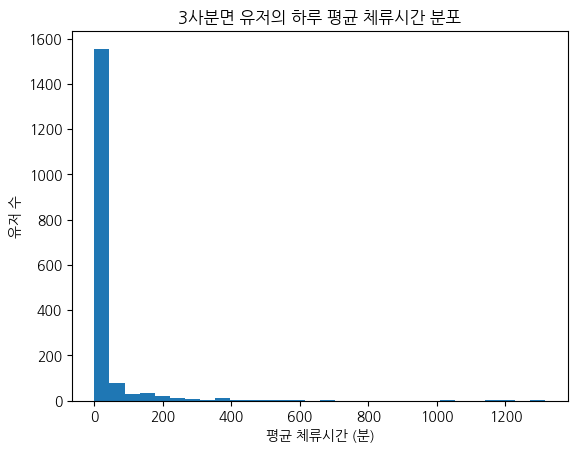

In [ ]:
plt.hist(user_avg_stay3['avg_daily_stay_min'], bins=30)
plt.xlabel('평균 체류시간 (분)')
plt.ylabel('유저 수')
plt.title('3사분면 유저의 하루 평균 체류시간 분포')
plt.show()

###### 사분면 집단별 특성 파악 (4사분면)

In [ ]:
fourth_q = matrix_df[matrix_df['사분면'] == '4사분면']

In [ ]:
basic_eda(fourth_q)

/tmp/ipython-input-4030955573.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_datetime(df[col].astype(str).str.replace(' UTC', '', regex=False), utc=True)
/tmp/ipython-input-4030955573.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce')
/tmp/ipython-input-4030955573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

✅ 칼럼 'timestamp'을(를) datetime(UTC 포함)으로 변환했습니다.
✅ 칼럼 'date_kst'을(를) datetime(UTC 포함)으로 변환했습니다.

[1] 데이터 크기 (행, 열):
(173202, 15) 

[2] 칼럼 이름과 데이터 타입:
- Unnamed: 0: int64
- user_uuid: object
- URL: object
- timestamp: datetime64[ns, UTC]
- date: datetime64[ns]
- response_code: int64
- method: object
- path: object
- query_string: object
- year: int64
- timestamp_utc: datetime64[ns, UTC]
- timestamp_kst: datetime64[ns, UTC+09:00]
- apply존재여부: int64
- 사분면: object
- date_kst: datetime64[ns]

[3] 각 칼럼 결측치 수와 중복값 수:
- Unnamed: 0: 결측치 0개, 중복값 203개, 고유값 172999개
- user_uuid: 결측치 0개, 중복값 172210개, 고유값 992개
- URL: 결측치 0개, 중복값 139970개, 고유값 33232개
- timestamp: 결측치 0개, 중복값 0개, 고유값 173202개
- date: 결측치 0개, 중복값 172473개, 고유값 729개
- response_code: 결측치 0개, 중복값 173193개, 고유값 9개
- method: 결측치 0개, 중복값 173198개, 고유값 4개
- path: 결측치 0개, 중복값 172997개, 고유값 205개
- query_string: 결측치 113368개, 중복값 141421개, 고유값 31780개
- year: 결측치 0개, 중복값 173200개, 고유값 2개
- timestamp_utc: 결측치 0개, 중복값 0개, 고유값 173202개
- timestamp_kst: 결측치 0개, 

In [ ]:
########### 방문일수 (중앙값 10)

In [ ]:
# 방문일수
fourth_q_active_days = fourth_q.groupby('user_uuid')['date_kst'].nunique()
fourth_q_active_days.describe()

,date_kst
count,992.000000
mean,14.665323
std,17.159691
min,6.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,287.000000


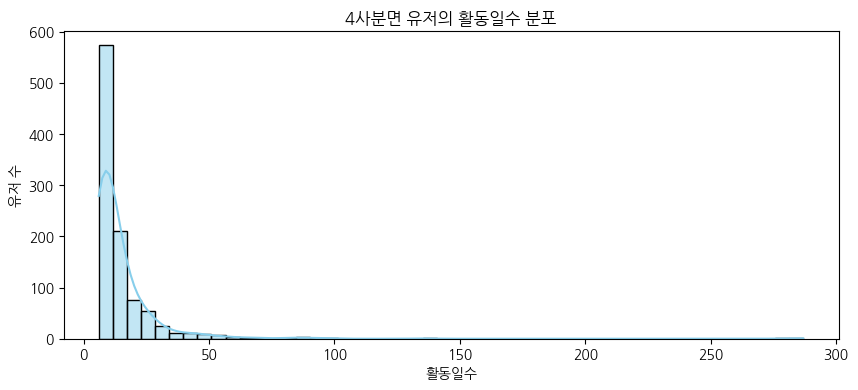

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(fourth_q_active_days, bins=50, kde=True, color='skyblue')
plt.title("4사분면 유저의 활동일수 분포")
plt.xlabel("활동일수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
########## 공고탐색 (중앙값 3)

In [ ]:
# 탐색수
fourth_q_job_title_counts = fourth_q.groupby('user_uuid')['path'].apply(lambda x: (x.str.contains('api/jobs/job_title|api/recommend_specialty', na=False)).sum())
fourth_q_job_title_counts.describe()

,path
count,992.000000
mean,3.518145
std,1.985740
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,7.000000


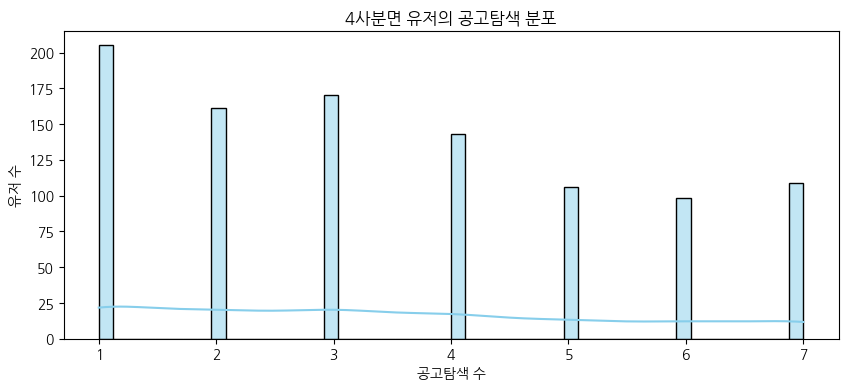

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(fourth_q_job_title_counts, bins=50, kde=True, color='skyblue')
plt.title("4사분면 유저의 공고탐색 분포")
plt.xlabel("공고탐색 수")
plt.ylabel("유저 수")
plt.show()

In [ ]:
########### 체류시간 (중앙값 15.075081)

In [ ]:
# 1. timestamp_kst가 datetime 형태인지 확인 및 변환
fourth_q['timestamp_kst'] = pd.to_datetime(fourth_q['timestamp_kst'], errors='coerce')

# 2. 날짜 컬럼 생성
fourth_q['date'] = fourth_q['timestamp_kst'].dt.date

# 3. 유저 × 날짜별 하루 체류시간 계산
daily_stay4 = (
    fourth_q.groupby(['user_uuid', 'date'])['timestamp_kst']
    .agg(['min', 'max'])  # 하루 중 첫 로그, 마지막 로그
    .reset_index()
)

# 4. 체류시간(초 단위) 계산
daily_stay4['stay_duration'] = (daily_stay4['max'] - daily_stay4['min']).dt.total_seconds()

# 5. 유저별 하루 평균 체류시간 계산 (초 단위)
user_avg_stay4 = (
    daily_stay4.groupby('user_uuid')['stay_duration']
    .mean()
    .reset_index()
    .rename(columns={'stay_duration': 'avg_daily_stay_sec'})
)

# 6. 시간 단위로 보기 좋게 변환 (예: 분 단위 추가)
user_avg_stay4['avg_daily_stay_min'] = user_avg_stay4['avg_daily_stay_sec'] / 60
user_avg_stay4['avg_daily_stay_hour'] = user_avg_stay4['avg_daily_stay_sec'] / 3600

# 7. 결과 확인
user_avg_stay4.describe()



/tmp/ipython-input-1516169939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_q['timestamp_kst'] = pd.to_datetime(fourth_q['timestamp_kst'], errors='coerce')
/tmp/ipython-input-1516169939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourth_q['date'] = fourth_q['timestamp_kst'].dt.date


,avg_daily_stay_sec,avg_daily_stay_min,avg_daily_stay_hour
count,992.000000,992.000000,992.000000
mean,2163.561844,36.059364,0.600989
std,3188.522581,53.142043,0.885701
min,5.559086,0.092651,0.001544
25%,181.374232,3.022904,0.050382
50%,904.504874,15.075081,0.251251
75%,2894.611581,48.243526,0.804059
max,28066.809414,467.780157,7.796336


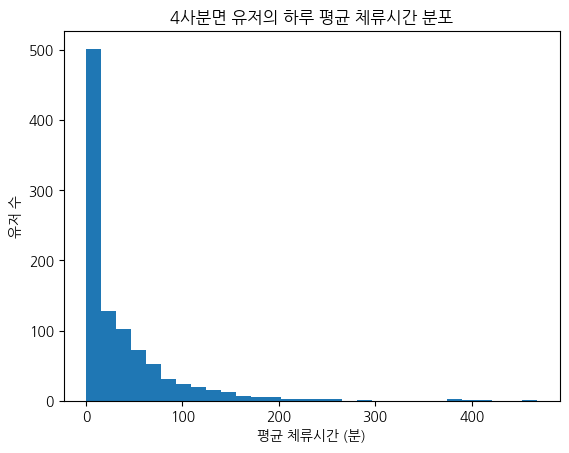

In [ ]:
plt.hist(user_avg_stay4['avg_daily_stay_min'], bins=30)
plt.xlabel('평균 체류시간 (분)')
plt.ylabel('유저 수')
plt.title('4사분면 유저의 하루 평균 체류시간 분포')
plt.show()

###### 사분면 중앙값 - 시각화

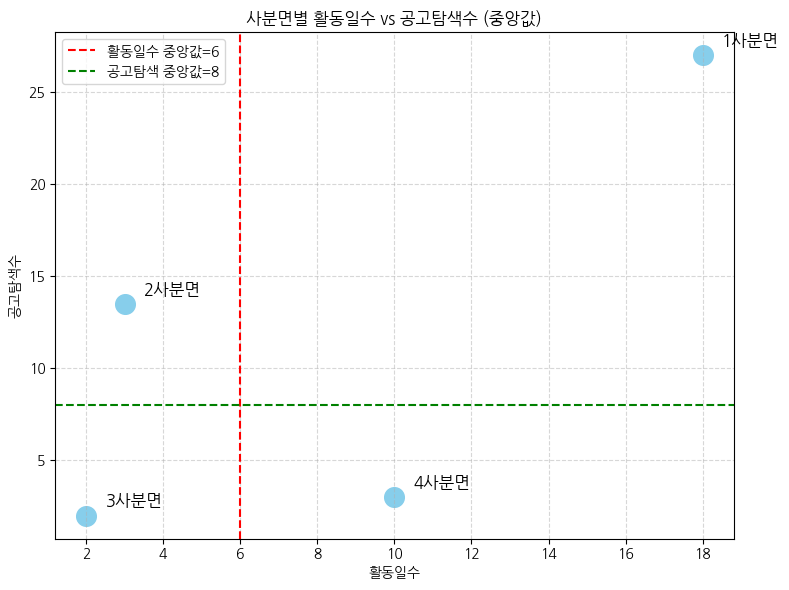

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------
# 데이터 정리
# ---------------------------------
data = {
    '사분면': ['1사분면', '2사분면', '3사분면', '4사분면'],
    '활동일수': [18, 3, 2, 10],
    '공고탐색수': [27, 13.5, 2, 3]
}

df = pd.DataFrame(data)

# 기준값
median_activity = 6
median_jobtitle = 8

# ---------------------------------
# 점 그래프
# ---------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df['활동일수'], df['공고탐색수'], s=200, color='skyblue')

# 기준선 추가
plt.axvline(x=median_activity, color='red', linestyle='--', label=f'활동일수 중앙값={median_activity}')
plt.axhline(y=median_jobtitle, color='green', linestyle='--', label=f'공고탐색 중앙값={median_jobtitle}')

# 각 점에 사분면 라벨 표시
for i, row in df.iterrows():
    plt.text(row['활동일수']+0.5, row['공고탐색수']+0.5, row['사분면'], fontsize=12)

plt.xlabel('활동일수')
plt.ylabel('공고탐색수')
plt.title('사분면별 활동일수 vs 공고탐색수 (중앙값)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


###### 사분면별 박스플롯

In [ ]:
from matplotlib import font_manager, rc
import platform

# 운영체제별 폰트 설정
if platform.system() == 'Darwin':  # Mac
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    rc('font', family='Malgun Gothic')
else:  # Colab / Linux
    !apt-get -qq install fonts-nanum > /dev/null
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    font_manager.fontManager.addfont(font_path)
    rc('font', family='NanumGothic')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
print("✅ 한글 폰트 설정 완료!")


✅ 한글 폰트 설정 완료!


/tmp/ipython-input-3364556662.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_all, x='quadrant', y='active_days', palette='Set2')


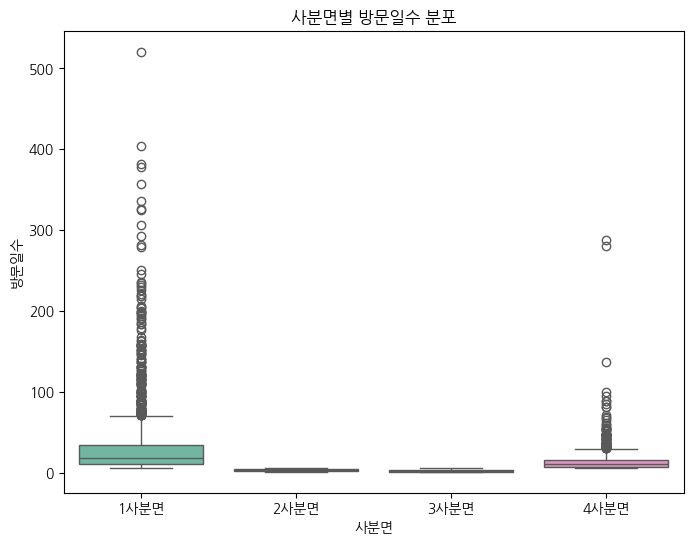

/tmp/ipython-input-3364556662.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_all, x='quadrant', y='job_search_count', palette='Set2')


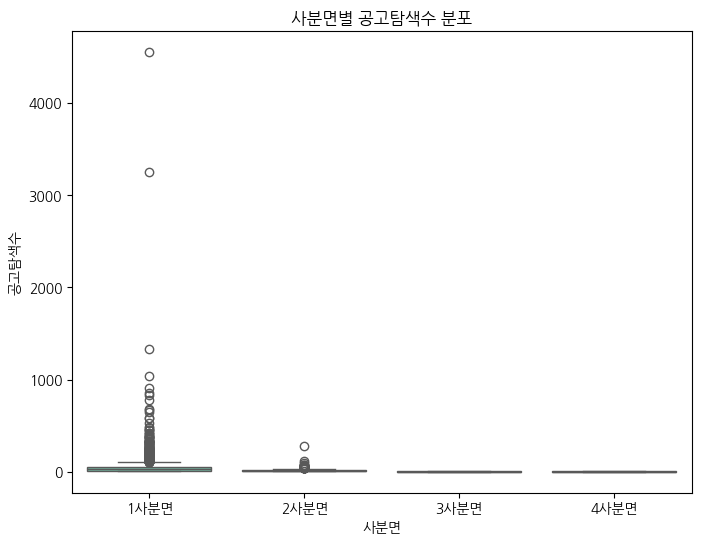

/tmp/ipython-input-3364556662.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_all, x='quadrant', y='avg_daily_stay_hour', palette='Set2')


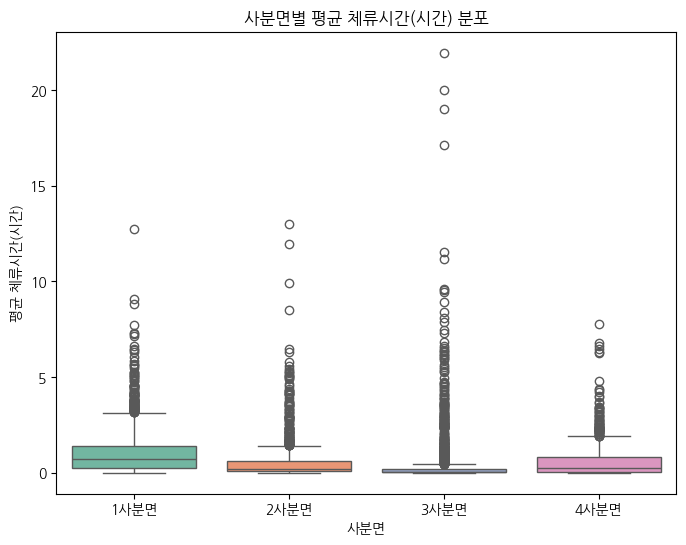

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 1️⃣ Series → DataFrame 변환
# ==========================
first_q_active_days = first_q_active_days.reset_index().rename(columns={'date_kst': 'active_days'})
second_q_active_days = second_q_active_days.reset_index().rename(columns={'date_kst': 'active_days'})
third_q_active_days = third_q_active_days.reset_index().rename(columns={'date_kst': 'active_days'})
fourth_q_active_days = fourth_q_active_days.reset_index().rename(columns={'date_kst': 'active_days'})

first_q_job_title_counts = first_q_job_title_counts.reset_index().rename(columns={'path': 'job_search_count'})
second_q_job_title_counts = second_q_job_title_counts.reset_index().rename(columns={'path': 'job_search_count'})
third_q_job_title_counts = third_q_job_title_counts.reset_index().rename(columns={'path': 'job_search_count'})
fourth_q_job_title_counts = fourth_q_job_title_counts.reset_index().rename(columns={'path': 'job_search_count'})

# ==========================
# 2️⃣ 사분면별 요약 DataFrame 생성 함수
# ==========================
def make_summary_df(active_days, job_counts, stay_df, label):
    df = (
        active_days
        .merge(job_counts, on='user_uuid', how='inner')
        .merge(stay_df[['user_uuid', 'avg_daily_stay_hour']], on='user_uuid', how='inner')
    )
    df['quadrant'] = label
    return df

# ==========================
# 3️⃣ 사분면별 DataFrame
# ==========================
q1 = make_summary_df(first_q_active_days, first_q_job_title_counts, user_avg_stay1, '1사분면')
q2 = make_summary_df(second_q_active_days, second_q_job_title_counts, user_avg_stay2, '2사분면')
q3 = make_summary_df(third_q_active_days, third_q_job_title_counts, user_avg_stay3, '3사분면')
q4 = make_summary_df(fourth_q_active_days, fourth_q_job_title_counts, user_avg_stay4, '4사분면')

summary_all = pd.concat([q1, q2, q3, q4], ignore_index=True)

# ==========================
# 4️⃣ 방문일수 박스플롯
# ==========================
plt.figure(figsize=(8,6))
sns.boxplot(data=summary_all, x='quadrant', y='active_days', palette='Set2')
plt.title('사분면별 방문일수 분포')
plt.ylabel('방문일수')
plt.xlabel('사분면')
plt.show()

# ==========================
# 5️⃣ 공고탐색수 박스플롯
# ==========================
plt.figure(figsize=(8,6))
sns.boxplot(data=summary_all, x='quadrant', y='job_search_count', palette='Set2')
plt.title('사분면별 공고탐색수 분포')
plt.ylabel('공고탐색수')
plt.xlabel('사분면')
plt.show()

# ==========================
# 6️⃣ 평균 체류시간(시간) 박스플롯
# ==========================
plt.figure(figsize=(8,6))
sns.boxplot(data=summary_all, x='quadrant', y='avg_daily_stay_hour', palette='Set2')
plt.title('사분면별 평균 체류시간(시간) 분포')
plt.ylabel('평균 체류시간(시간)')
plt.xlabel('사분면')
plt.show()


##### 전환형 집단 EDA
- 탐색형집단의 성공지표로 삼을만한 지표 찾기
- step1진입횟수와 다양한 지표간의 상관관계 분석
- 상관성이 있는 것으로 나타난 지표의 분포파악

###### 전환형에서 공고탐색 횟수와 지원횟수의 상관관계

In [ ]:
# 1) 유저별 활동일수 계산
activity_days = log_df.copy()
activity_days['date'] = activity_days['timestamp_kst'].dt.date
activity_days = activity_days.groupby('user_uuid')['date'].nunique().reset_index()
activity_days = activity_days.rename(columns={'date': 'unique_active_days'})

# 2) 유저별 step1 진입 횟수 계산
step1_hits = log_df[log_df['path'] == 'api/jobs/id/apply/step1']
step1_hits = step1_hits.groupby('user_uuid').size().reset_index(name='step1_hits')

# 3) 병합
user_stats = activity_days.merge(step1_hits, on='user_uuid', how='left')

# NaN → 0 처리
user_stats['step1_hits'] = user_stats['step1_hits'].fillna(0).astype(int)


In [ ]:
# 4) step1_hits > 0 인 유저만 필터
filtered = user_stats[user_stats['step1_hits'] > 0]

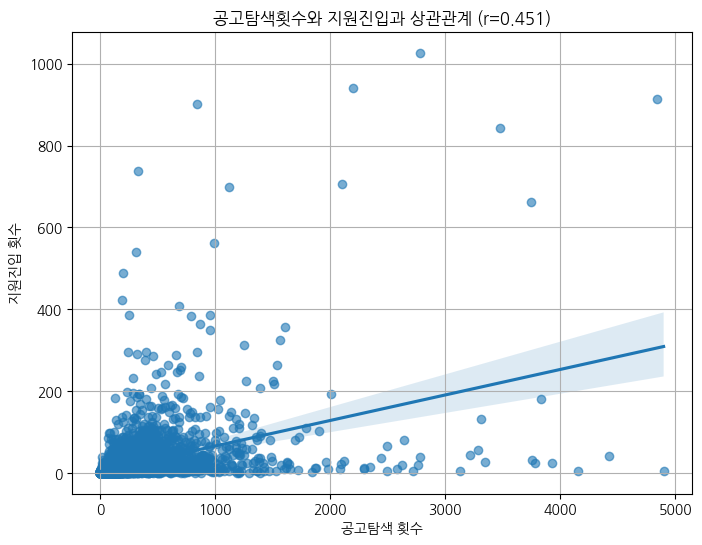

In [ ]:
# 1) exclude_paths 호출 횟수 세기
exclude_hits = log_df[log_df['path'].isin(["api/jobs/job_title", "api/recommend_specialty"])] \
    .groupby('user_uuid').size().reset_index(name='exclude_path_hits')

# 2) 기존 step1_hits랑 merge
data = user_stats[['user_uuid', 'step1_hits','unique_active_days']].merge(exclude_hits, on='user_uuid', how='left')

# 결측치는 0으로
data['exclude_path_hits'] = data['exclude_path_hits'].fillna(0)

# 3) step1_hits > 0 인 유저만
filtereds = data[data['step1_hits'] > 0]

# 4) 상관계수 계산
from scipy.stats import pearsonr
corr, p_value = pearsonr(filtereds['exclude_path_hits'], filtereds['step1_hits'])

# 5) 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.regplot(data=filtereds, x='exclude_path_hits', y='step1_hits', scatter_kws={'alpha':0.6})

plt.title(f'공고탐색횟수와 지원진입과 상관관계 (r={corr:.3f})')
plt.xlabel('공고탐색 횟수')
plt.ylabel('지원진입 횟수')
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


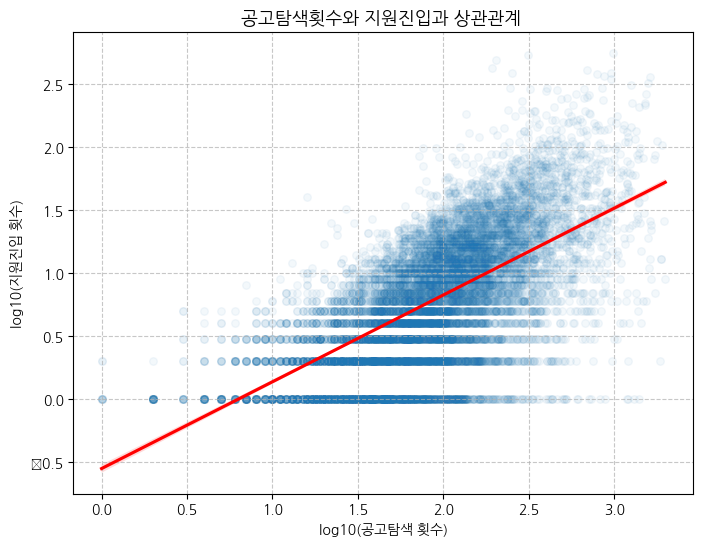

In [ ]:
# 1️⃣ 극단값 제거
filtered_log = filtereds[
    (filtereds['exclude_path_hits'] <= 2000) &
    (filtereds['step1_hits'] <= 600)
]
filtered_log = filtered_log[
    (filtered_log['exclude_path_hits'] > 0) &
    (filtered_log['step1_hits'] > 0)
]

# 2️⃣ 로그 변환
filtered_log['log_exclude'] = np.log10(filtered_log['exclude_path_hits'])
filtered_log['log_step1'] = np.log10(filtered_log['step1_hits'])

# 3️⃣ 상관계수 (로그값 기준)
corr, _ = pearsonr(filtered_log['log_exclude'], filtered_log['log_step1'])

# 4️⃣ regplot (진짜 선형회귀선)
plt.figure(figsize=(8,6))
sns.regplot(
    data=filtered_log,
    x='log_exclude',
    y='log_step1',
    scatter_kws={'alpha':0.05, 's':30},
    line_kws={'color':'red'}
)

plt.title(f'공고탐색횟수와 지원진입과 상관관계 ', fontsize=13)
plt.xlabel('log10(공고탐색 횟수)')
plt.ylabel('log10(지원진입 횟수)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

###### 전환형의 공고탐색, 활동일수, 지원단계진입횟수 기술통계

In [ ]:
summary = filtereds.rename(columns={
    'step1_hits': '지원단계진입 횟수',
    'unique_active_days': '활동일 수',
    'exclude_path_hits': '공고탐색 횟수',
})

In [ ]:
summary.describe()

,지원단계진입 횟수,활동일 수,공고탐색 횟수
count,10693.000000,10693.000000,10693.000000
mean,13.778266,37.543720,160.570093
std,35.076197,46.333502,253.867294
min,1.000000,1.000000,1.000000
25%,3.000000,10.000000,46.000000
50%,6.000000,23.000000,93.000000
75%,14.000000,46.000000,177.000000
max,1027.000000,546.000000,4898.000000


###### 탐색횟수 대비 지원단계 진입 유저 의 분포

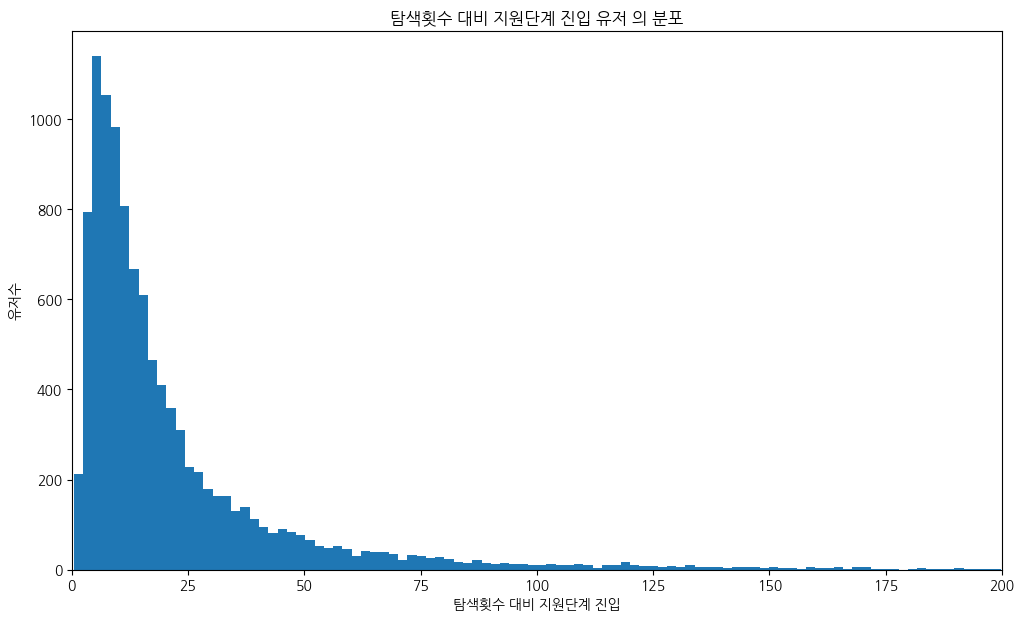

In [ ]:
filtered_200 = filtereds[(filtereds['나누기'] >= 0) & (filtereds['나누기'] <= 200)]

plt.figure(figsize=(12, 7))
plt.hist(filtered_200['나누기'], bins=100)
plt.title('탐색횟수 대비 지원단계 진입 유저 의 분포')
plt.xlabel('탐색횟수 대비 지원단계 진입')
plt.ylabel('유저수')
plt.xlim(0, 200)  # x축 범위 직접 제한
plt.show()

###### 체류시간과 지원단계 진입 상관관계

극단값 및 0 값 제거 후 데이터 수: 12437개
로그 변환 후 상관계수 (r): 0.6619
p-value: 0.0000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


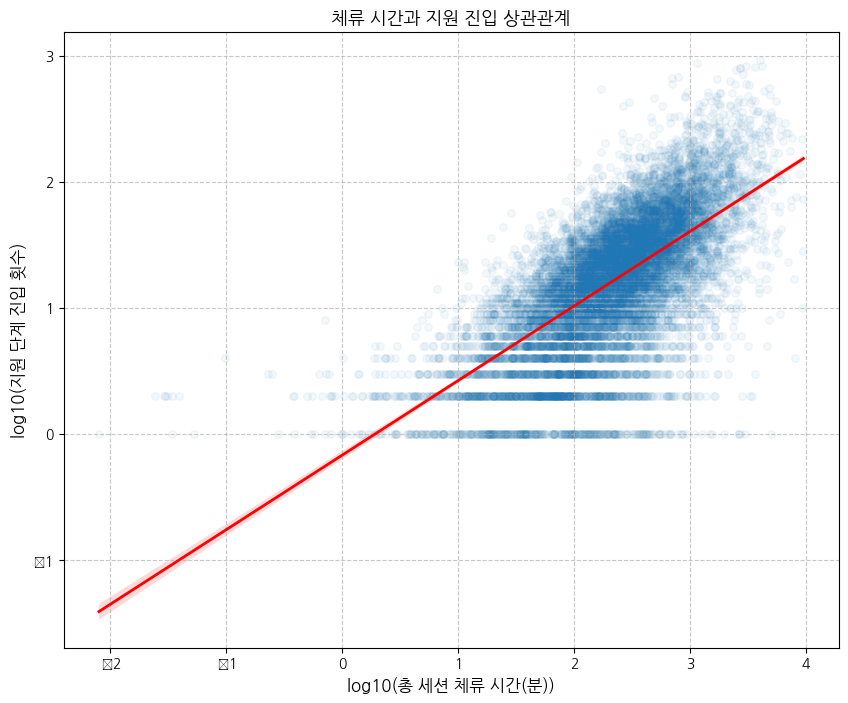

3368

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import gc; gc.collect()

# ----------------- 0. 전제: correlation_df 사용 -----------------
# 이전 단계에서 생성된 DataFrame 변수 이름: correlation_df
# 포함된 컬럼: 'total_active_duration_min', 'step1_entry_count'

# ----------------- 1️⃣ 극단값 제거 및 0 값 필터링 -----------------
# 필터링할 DataFrame을 correlation_df에서 복사
filtered_log = correlation_df.copy()

# 극단값 제거 (임계값 10000분, 1000회)
# 참고: 이 임계값은 데이터 분포에 따라 조절해야 합니다.
filtered_log = filtered_log[
    (filtered_log['total_active_duration_min'] <= 10000) &
    (filtered_log['step1_entry_count'] <= 1000)
]

# 로그 변환을 위해 0 값 제거 (log(0)은 정의되지 않으므로 필수)
filtered_log = filtered_log[
    (filtered_log['total_active_duration_min'] > 0) &
    (filtered_log['step1_entry_count'] > 0)
].reset_index(drop=True)

# 메모리 절약을 위해 원본 correlation_df를 삭제할 수도 있습니다.
# del correlation_df
gc.collect()

print(f"극단값 및 0 값 제거 후 데이터 수: {len(filtered_log)}개")

# ----------------- 2️⃣ 로그 변환 (Log10) -----------------
# NumPy의 log10 함수를 사용하여 변환
filtered_log['log_duration'] = np.log10(filtered_log['total_active_duration_min'])
filtered_log['log_step1'] = np.log10(filtered_log['step1_entry_count'])

# ----------------- 3️⃣ 상관계수 (로그값 기준) -----------------
# scipy.stats.pearsonr 함수 사용
corr, p_value = pearsonr(filtered_log['log_duration'], filtered_log['log_step1'])

print(f"로그 변환 후 상관계수 (r): {corr:.4f}")
print(f"p-value: {p_value:.4f}") # p-value가 0.05 미만이면 통계적으로 유의미함

# ----------------- 4️⃣ regplot (선형 회귀선 시각화) -----------------
plt.figure(figsize=(10,8))

# regplot으로 산점도와 추세선을 동시에 그림
sns.regplot(
    data=filtered_log,
    x='log_duration',
    y='log_step1',
    scatter_kws={'alpha':0.05, 's':30}, # 투명도 및 크기 설정
    line_kws={'color':'red', 'linewidth': 2}
)

# 5. 제목 및 축 레이블 설정
plt.title(f'체류 시간과 지원 진입 상관관계', fontsize=13)
plt.xlabel('log10(총 세션 체류 시간(분))', fontsize=12)
plt.ylabel('log10(지원 단계 진입 횟수)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 6. 그래프 출력
plt.show()

# 최종 메모리 정리
del filtered_log
gc.collect()

###### 활동일수, 지원단계 진입횟수, 공고탐색횟수, 평균체류시간에 박스플롯

In [ ]:
# --- 1) 유저별 활동일수 계산 ---
activity_days = log_df.copy()
activity_days['date'] = activity_days['timestamp_kst'].dt.date
activity_days = (
    activity_days.groupby('user_uuid')['date']
    .nunique()
    .reset_index()
    .rename(columns={'date': 'unique_active_days'})
)

# --- 2) 유저별 step1 진입 횟수 ---
step1_hits = (
    log_df[log_df['path'] == 'api/jobs/id/apply/step1']
    .groupby('user_uuid')
    .size()
    .reset_index(name='step1_hits')
)

# --- 3) 병합 ---
user_stats = activity_days.merge(step1_hits, on='user_uuid', how='left')
user_stats['step1_hits'] = user_stats['step1_hits'].fillna(0).astype(int)

# --- 4) 조회 행동 관련 분석 추가 ---
target_paths = ["api/jobs/job_title", "api/recommend_specialty"]

# datetime 변환
log_df['timestamp_kst'] = pd.to_datetime(log_df['timestamp_kst'], errors='coerce')

# (1) 유저별 조회 행동 횟수
view_counts = (
    log_df[log_df['path'].isin(target_paths)]
    .groupby('user_uuid')['path']
    .count()
    .reset_index(name='view_action_count')
)

# (2) 유저별 평균 세션 체류시간
log_df['date'] = log_df['timestamp_kst'].dt.date
session_df = (
    log_df.groupby(['user_uuid', 'date'])['timestamp_kst']
    .agg(['min', 'max'])
    .reset_index()
)
session_df['session_duration_min'] = (session_df['max'] - session_df['min']).dt.total_seconds() / 60

avg_session_time = (
    session_df.groupby('user_uuid')['session_duration_min']
    .mean()
    .reset_index(name='avg_session_duration_min')
)

# --- 5) 조회 행동 + 체류시간 병합 ---
user_behavior = view_counts.merge(avg_session_time, on='user_uuid', how='outer').fillna(0)

# --- 6) 기존 user_stats와 통합 ---
user_summary = user_stats.merge(user_behavior, on='user_uuid', how='left').fillna(0)

# --- 7) 결과 확인 ---


sns.set(style="whitegrid", font="Malgun Gothic")  # 한글 깨짐 방지 (Windows 기준)
plt.rcParams['axes.unicode_minus'] = False

# 시각화 대상 변수와 라벨 매핑
metrics = {
    'unique_active_days': '활동일 수',
    'step1_hits': '지원단계진입 횟수',
    'view_action_count': '공고탐색 횟수',
    'avg_session_duration_min': '평균 체류시간(분)'
}

# 각 변수별 박스플롯 (일반 스케일만)
for col, label in metrics.items():
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=user_summary, y=col, color='skyblue')
    plt.title(f'{label} 분포 ', fontsize=14)
    plt.ylabel(label)
    plt.tight_layout()
    plt.show()

# 여기서는 전환형에 대해서 박스플롯을 띄우는 것인데 코랩이 아무리 최적화를 해도 코랩자체 램이 12기가밖에 지원하지 않아 실행 결과가 없습니다. 로컬 환경에서 실행한 결과가 보고서에 따로 첨부되어져 있습니다.
# 여기서 각 활동일수, 지원단계 진입횟수, 공고탐색횟수, 평균체류시간 에 대한 전체적인 데이터의 분산을 보기 위한 작업의 결과입니다.